# Predcition of Hospital Admission Related to Combiination of Upper Respiratory Tract Infection, Cough, Cold with Cough, and Sore Throat

In this notebook, we develop Cox proportional hazard regression models to predict the risk of hospital admission related to upper respiratory tract infection, urti_combined, cough cold, and sore throat combinied together, called urti_combined. We, then, analyse whether prescribing antibiotics is based on the risk of hospital admission or not by building logistic regression (LR) and random forest (RF) models.

In [35]:
import pandas as pd
import matplotlib
from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
import numpy as np
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_curve, roc_auc_score
import statsmodels.api as sm
from scipy import stats
from statsmodels.formula.api import logit
from datetime import date
from operator import attrgetter
import io
from contextlib import redirect_stdout
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

## 0- functions

In [36]:
#function to transform cph model summary and save it as html
def GetPrintSummary(model):
    output = ""
    with io.StringIO() as buf, redirect_stdout(buf):
        model.print_summary(style="html")
        output = buf.getvalue()
    return output

In [37]:
#round counts in a way that the last digit become 0 or 5
def round_five_mul(x, base=5):
    return base * round(x/base)

In [38]:
#function to process urti_combined data
def proc_infec_data_combined_urti(data, infection):
    #rename variables with i
    for i in range(1,21):
        data.rename(columns={infection+'_date_'+str(i): 'urti_combined_date_'+str(i), infection+'_ab_date_'+str(i): 'urti_combined_ab_date_'+str(i),
                            infection+'_ab_type_'+str(i): 'urti_combined_ab_type_'+str(i), 'incdt_'+infection+'_date_'+str(i): 'incdt_urti_combined_date_'+str(i), 
                            'incdt_'+infection+'_type_'+str(i): 'incdt_urti_combined_type_'+str(i), 'admitted_'+infection+'_date_'+str(i): 'admitted_urti_combined_date_'+str(i),
                            'gp_covid_date_'+infection+'_'+str(i): 'gp_covid_date_combined_urti_'+str(i), 'sgss_gp_cov_'+infection+'_date_'+str(i): 'sgss_gp_cov_urti_combined_date_'+str(i),
                            'sgss_pos_covid_date_'+infection+'_'+str(i): 'sgss_pos_covid_date_urti_combined_'+str(i), infection+'_ab_count_'+str(i): 'urti_combined_ab_count_'+str(i)},
                    inplace=True)
    
    return data

In [39]:
#function to process infection data 
def proc_infec_data(data, i):
    datum = data
    datum = datum[['age', 'age_cat', 'sex', 'flu_vaccine', 'smoking_status', 'bmi', 'imd', 'ethnicity', 
                   'region', 'CCI', 'died_date', 'deregistered_date', 'practice', 
                   'antibacterial_brit_'+str(i), 'urti_combined_date_'+str(i), 'urti_combined_ab_date_'+str(i), 'urti_combined_ab_type_'+str(i),
                   'incdt_urti_combined_date_'+str(i), 'admitted_urti_combined_date_'+str(i), 'sgss_gp_cov_urti_combined_date_'+str(i)]]
    
    #drop rows with no urti_combined reord
    datum = datum[datum['urti_combined_date_'+str(i)].notnull()]
    #exclusion of covid positive 90 days before and 30 days after dx with urti_combined_i
    datum = datum[datum['sgss_gp_cov_urti_combined_date_'+str(i)] == 0]
    #rename variables with i
    datum.rename(columns={'urti_combined_date_'+str(i): 'urti_combined_date', 'urti_combined_ab_date_'+str(i): 'urti_combined_ab_date', 
                           'urti_combined_ab_type_'+str(i): 'ab_type', 'antibacterial_brit_'+str(i): 'antibacterial_brit',
                           'incdt_urti_combined_date_'+str(i): 'incdt_urti_combined_date', 'incdt_urti_combined_type_'+str(i): 'incdt_urti_combined_type',
                           'admitted_urti_combined_date_'+str(i): 'admitted_urti_combined_date',
                           'sgss_gp_cov_urti_combined_date_'+str(i): 'sgss_gp_cov_urti_combined_date'},
                inplace=True)
    
    return datum

In [40]:
#preparation of data for cox models
def cox_data_prep(data, vars, vars_countinuous, vars_output):
    data_req = data[vars+vars_countinuous+vars_output]
    #encoding categorical data for cox models
    data_enc = data_req[vars+vars_countinuous].reset_index()
    #creating instance of one-hot-encoder
    enc = OneHotEncoder()
    data_req_enc = pd.DataFrame(enc.fit_transform(data_enc[vars]).toarray())
    data_req_enc.columns = enc.get_feature_names(data_enc[vars].columns)
    data_req_enc = data_enc[vars_countinuous].join(data_req_enc) 

    return data_req_enc

In [41]:
#summary table of baseline characteristics
def make_summary_table(infection, infection_type, prob_pred_enc_lr_rf):
    #calculate sums
    summary_table = prob_pred_enc_lr_rf.sum(axis=0).reset_index()
    summary_table.columns = ['variable', 'count']
    #round count to make last digit either 0 or 5
    summary_table['mean'] = prob_pred_enc_lr_rf.mean(axis=0).reset_index()[0]
    summary_table['count'] = round_five_mul(summary_table['count'], base=5)
    summary_table['std'] = prob_pred_enc_lr_rf.std(axis=0).reset_index()[0]
    #replace small counts (<=5) with 'SM'
    summary_table.loc[(summary_table['count'] <= 5), 'count'] = 'SM'

    #save table
    summary_table.to_csv('../output/hospitalisation_prediction_'+infection+'/summary_table_'+infection+'_'+infection_type+'.csv', index=False)

In [42]:
def cox_build(infection, infection_type, data, data_no_abs): #data_urti_combined_incdt, data_urti_combined_no_abs_incdt
    #randomly splitting data into training (%75) and testing (%25)
    data_dev, data_val = train_test_split(data_no_abs, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_dev,
            duration_col='duration_urti_combined_admitted',
            event_col='event_urti_combined_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    ##add deciles of predicted risks and probability of prescribed antibiotics
    #predict cumulative hazard in day 30 in train dataset
    prob_pred = cph.predict_cumulative_hazard(data[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit']]).loc[[30]].T
    prob_pred.columns = ['pred']
    #prob_pred_urti_combined_no_abs_incdt

    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred['bins'] = pd.qcut(prob_pred['pred'], 10)
    #prob_pred

    ##add a column for prescribed antibiotics
    prob_pred = pd.concat([prob_pred, data[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit', 'ab_binary']]], axis=1)
    #prob_pred

    ###needed for figures
    #groupby bins to find mean predicted probability for each bin (pred_mean) and mean probability of being prescribed antibiotics (ab_prob_mean)
    prob_pred_bin = prob_pred.groupby('bins')[['pred', 'ab_binary']].agg(['mean', 'sum', 'count']).reset_index()
    prob_pred_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'ab_prob_mean', 'ab_prob_sum', 'ab_prob_count']
    prob_pred_bin['bins'] = prob_pred_bin['bins'].astype(str)
    #prob_pred_urti_combined_no_abs_incdt_bin
    prob_pred_bin.to_csv('../output/hospitalisation_prediction_'+infection+'/prob_pred_bin_'+infection+'_'+infection_type+'.csv', index=False)

    #plot
    plt.figure(figsize=(10,7))
    sns.lineplot(x='bins', y='ab_prob_mean', data=prob_pred_bin, marker='o', markersize=10)
    g = sns.lineplot(x="bins", data=prob_pred_bin, y="ab_prob_mean", marker='*', linestyle='--', markersize=10)
    plt.ylim(0)#, data.pred_mean_train.max() + data.pred_mean_train.max()/3)
    plt.xlim(0)#, data.ab_prob_mean_train.max() + data.ab_prob_mean_train.max()/3)
    plt.setp(g.collections, alpha=.5) #alpha for markers
    plt.setp(g.lines, alpha=.5) #alpha for line
    plt.xlabel('Decile', fontsize=14)
    plt.ylabel('Mean probability of prescribing antibiotic', fontsize=14)
    plt.gca().set_xticks(np.arange(0,10,1), minor=True)
    plt.grid(b=True, which='major', color='k', linestyle=':', alpha=0.5)
    plt.grid(which='minor', color='k', linestyle=':', alpha=0.5)
    plt.xticks(prob_pred_bin.bins, rotation=90)
    # plt.legend([],[], frameon=False)
    # plt.savefig('../output/aggregate_ab_prob/aggregate_ab_prob_incdt.jpg')
    plt.show()

    return prob_pred, prob_pred_bin

In [43]:
def lr_rf_build_risk(infection, infection_type, prob_pred):
    ##data prep
    prob_pred['bins'] = prob_pred['bins'].astype(str)
    #creating instance of one-hot-encoder with development data
    enc = OneHotEncoder()
    prob_pred_enc = pd.DataFrame(enc.fit_transform(prob_pred[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'bins']]).toarray())
    prob_pred_enc.columns = enc.get_feature_names(prob_pred[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'bins']].columns)
    #dataframe for lr and rf modelling 
    prob_pred = prob_pred.reset_index(drop=True)
    prob_pred_enc_lr_rf = pd.concat([prob_pred_enc, prob_pred[['antibacterial_brit', 'ab_binary']]], axis=1)
    #prob_pred_enc_lr_rf

    ##rf, lr modelling
    #randomly splitting data into training (%75) and testing (%25)
    data_enc_dev, data_enc_val = train_test_split(prob_pred_enc_lr_rf, test_size=0.25)#, random_state=42)
    data_enc_dev_y = data_enc_dev[['ab_binary']]
    data_enc_dev_x = data_enc_dev.drop('ab_binary', axis=1)
    data_enc_val_y = data_enc_val[['ab_binary']]
    data_enc_val_x = data_enc_val.drop('ab_binary', axis=1)

    ##building lr model
    lr = sm.Logit(endog=data_enc_dev_y, exog=data_enc_dev_x)
    lr = lr.fit(disp=0)
    #predict probabilities of lr model
    lr_pred_dev = lr.predict(data_enc_dev_x)
    lr_pred_val = lr.predict(data_enc_val_x)

    ##building rf model
    rf = RandomForestClassifier(n_estimators=200, max_leaf_nodes=30, max_depth=20)
    rf.fit(data_enc_dev_x, data_enc_dev_y)
    #predict probabilities to rf model
    rf_pred_dev = rf.predict_proba(data_enc_dev_x)[:,1]
    rf_pred_val = rf.predict_proba(data_enc_val_x)[:,1]

    #print aurocs
    auroc_lr_dev = sklearn.metrics.roc_auc_score(data_enc_dev_y, lr_pred_dev)
    auroc_lr_val = sklearn.metrics.roc_auc_score(data_enc_val_y, lr_pred_val)
    auroc_rf_dev = roc_auc_score(data_enc_dev_y, rf_pred_dev)
    auroc_rf_val = roc_auc_score(data_enc_val_y, rf_pred_val)
    print('\nLR AUROC with development and validation data: %.5f'%(auroc_lr_dev), 'and %.5f' % (auroc_lr_val))
    print('RF AUROC with development and validation data: %.5f'%(auroc_rf_dev), 'and %.5f' % (auroc_rf_val))

    #print summary of LR model
    lr_coef = pd.DataFrame({"OR": lr.params, "Lower CI": lr.conf_int()[0], "Upper CI": lr.conf_int()[1],})
    lr_coef = np.exp(lr_coef)
    lr_coef.to_csv('../output/hospitalisation_prediction_'+infection+'/coefs_lr_'+infection+'_'+infection_type+'.csv')
    print('LR coefficients:\n %s'%(lr_coef))

    #print parameters of grid search
    # print("\nRF parameters after grid search:", rf)

    #print feature importance of RF model
    rf_coef = pd.DataFrame(data=rf.feature_importances_, index=data_enc_dev_x.columns, columns=['rf_coef'])#.sort_values(by=['feature_importance'], ascending=False)
    rf_coef = rf_coef.sort_values('rf_coef', ascending=False)
    lr_coef.to_csv('../output/hospitalisation_prediction_'+infection+'/coefs_rf_'+infection+'_'+infection_type+'.csv')
    print('\nRF feature importance:\n %s'%(rf_coef))

    #plot roc curves
    r_fpr_lr_dev, r_tpr_lr_dev, _ = roc_curve(data_enc_dev_y, lr_pred_dev)
    r_fpr_lr_val, r_tpr_lr_val, _ = roc_curve(data_enc_val_y, lr_pred_val)
    r_fpr_rf_dev, r_tpr_rf_dev, _ = roc_curve(data_enc_dev_y, rf_pred_dev)
    r_fpr_rf_val, r_tpr_rf_val, _ = roc_curve(data_enc_val_y, rf_pred_val)

    fig, ax1 = pyplot.subplots(figsize=(7, 7))
    line_lr_dev, = plt.plot(r_fpr_lr_dev, r_tpr_lr_dev, linestyle='-', marker='o', markersize=6, markevery=0.1, color='#408678', label='LR with development data')
    line_lr_val, = plt.plot(r_fpr_lr_val, r_tpr_lr_val, linestyle='--', marker='v', markersize=6, markevery=0.1, color='#6ce0c9', label='LR with validation data')
    line_rf_dev, = plt.plot(r_fpr_rf_dev, r_tpr_rf_dev, linestyle='-', marker='o', markersize=6, markevery=0.1, color='#8D576D', label='RF with development data')
    line_rf_val, = plt.plot(r_fpr_rf_val, r_tpr_rf_val, linestyle='--', marker='v', markersize=6, markevery=0.1, color='#eb91b7', label='RF with validation data')
    
    squares = [0,1.01] 
    plt.plot(squares,linewidth=1, color='grey')
    plt.ylim(0,1.01)
    plt.xlim(0,1)
    plt.xlabel('Specificity', fontsize=14)
    plt.ylabel('Sensitivity', fontsize=14)
    
    #reversing xticks
    xticks = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]
    x = np.arange(len(xticks))
    ax1.set(xticklabels=xticks)
    ax1.legend(fontsize=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10, rotation=0)
    # plt.title("ROC curve of LR and RF model", fontsize=14)
    plt.savefig('../output/hospitalisation_prediction_'+infection+'/roc_'+infection+'_'+infection_type+'.jpg', bbox_inches='tight')
    plt.show()
    
    return prob_pred_enc_lr_rf, data_enc_dev, data_enc_val, lr_pred_dev, lr_pred_val, rf_pred_dev, rf_pred_val

In [44]:
def calibration_rf_lr(infection, infection_type, data_enc_dev, data_enc_val, lr_pred_dev, lr_pred_val, rf_pred_dev, rf_pred_val):
    ##calibration for RF
    rf_prob_pred_dev = pd.DataFrame(data=rf_pred_dev, columns=['pred'])
    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    rf_prob_pred_dev['bins'] = pd.qcut(rf_prob_pred_dev['pred'], 10, duplicates="drop")
    #merge cumulative hazards with their actual events (0, 1)
    rf_prob_pred_dev = pd.merge(rf_prob_pred_dev, data_enc_dev['ab_binary'], left_index=True, right_index=True)
    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    rf_prob_pred_dev_groupby_bin = rf_prob_pred_dev.groupby('bins')[['pred', 'ab_binary']].agg(['mean', 'sum', 'count']).reset_index()
    rf_prob_pred_dev_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'ab_binary_mean', 'ab_binary_sum', 'ab_binary_count']
    #calculate proportion of events in each bin
    rf_prob_pred_dev_groupby_bin['ab_binary_proportion'] = rf_prob_pred_dev_groupby_bin['ab_binary_sum']/rf_prob_pred_dev_groupby_bin['ab_binary_count']
    #
    rf_prob_pred_val = pd.DataFrame(data=rf_pred_val, columns=['pred'])
    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    rf_prob_pred_val['bins'] = pd.qcut(rf_prob_pred_val['pred'], 10, duplicates="drop")
    #merge cumulative hazards with their actual events (0, 1)
    rf_prob_pred_val = pd.merge(rf_prob_pred_val, data_enc_val['ab_binary'], left_index=True, right_index=True)
    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    rf_prob_pred_val_groupby_bin = rf_prob_pred_val.groupby('bins')[['pred', 'ab_binary']].agg(['mean', 'sum', 'count']).reset_index()
    rf_prob_pred_val_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'ab_binary_mean', 'ab_binary_sum', 'ab_binary_count']
    #calculate proportion of events in each bin
    rf_prob_pred_val_groupby_bin['ab_binary_proportion'] = rf_prob_pred_val_groupby_bin['ab_binary_sum']/rf_prob_pred_val_groupby_bin['ab_binary_count']
    #plot calibration plot for RF model with development and validation data
    fig, ax1 = plt.subplots(figsize=(7, 7))
    plt.plot(rf_prob_pred_dev_groupby_bin.pred_mean, rf_prob_pred_dev_groupby_bin['ab_binary_proportion'], color='#8D576D', linestyle='solid', marker='o', alpha=0.9)
    plt.plot(rf_prob_pred_val_groupby_bin.pred_mean, rf_prob_pred_val_groupby_bin['ab_binary_proportion'], color='#eb91b7', linestyle='dashed', marker='v', alpha=0.9)
    plt.xlabel('Mean predicted probabilities', fontsize=14)
    plt.ylabel('Proportion of observed values', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.xlim(0, max(rf_prob_pred_dev_groupby_bin.pred_mean.max(), rf_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2) + (max(rf_prob_pred_dev_groupby_bin.pred_mean.max(), rf_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2)/3))
    plt.ylim(0, max(rf_prob_pred_dev_groupby_bin.pred_mean.max(), rf_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2) + (max(rf_prob_pred_dev_groupby_bin.pred_mean.max(), rf_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2)/3))
    plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
    plt.title("Calibration plot of RF model", fontsize=14)
    legend_dev = mlines.Line2D([], [], color='#8D576D', linestyle='-', marker='o', markersize=10, label='Development data', alpha=.9)
    legend_val = mlines.Line2D([], [], color='#eb91b7', linestyle='--', marker='v', markersize=10, label='Validation data', alpha=.9)
    plt.legend(handles=[legend_dev, legend_val])
    plt.savefig('../output/hospitalisation_prediction_'+infection+'/calib_rf_'+infection+'_'+infection_type+'.jpg', bbox_inches='tight')
    plt.show()

    ##calibration for LR
    lr_prob_pred_dev = pd.DataFrame(data=lr_pred_dev, columns=['pred'])
    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    lr_prob_pred_dev['bins'] = pd.qcut(lr_prob_pred_dev['pred'], 10, duplicates="drop")
    #merge cumulative hazards with their actual events (0, 1)
    lr_prob_pred_dev = pd.merge(lr_prob_pred_dev, data_enc_dev['ab_binary'], left_index=True, right_index=True)
    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    lr_prob_pred_dev_groupby_bin = lr_prob_pred_dev.groupby('bins')[['pred', 'ab_binary']].agg(['mean', 'sum', 'count']).reset_index()
    lr_prob_pred_dev_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'ab_binary_mean', 'ab_binary_sum', 'ab_binary_count']
    #calculate proportion of events in each bin
    lr_prob_pred_dev_groupby_bin['ab_binary_proportion'] = lr_prob_pred_dev_groupby_bin['ab_binary_sum']/lr_prob_pred_dev_groupby_bin['ab_binary_count']
    #
    lr_prob_pred_val = pd.DataFrame(data=lr_pred_val, columns=['pred'])
    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    lr_prob_pred_val['bins'] = pd.qcut(lr_prob_pred_val['pred'], 10, duplicates="drop")
    #merge cumulative hazards with their actual events (0, 1)
    lr_prob_pred_val = pd.merge(lr_prob_pred_val, data_enc_val['ab_binary'], left_index=True, right_index=True)
    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    lr_prob_pred_val_groupby_bin = lr_prob_pred_val.groupby('bins')[['pred', 'ab_binary']].agg(['mean', 'sum', 'count']).reset_index()
    lr_prob_pred_val_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'ab_binary_mean', 'ab_binary_sum', 'ab_binary_count']
    #calculate proportion of events in each bin
    lr_prob_pred_val_groupby_bin['ab_binary_proportion'] = lr_prob_pred_val_groupby_bin['ab_binary_sum']/lr_prob_pred_val_groupby_bin['ab_binary_count']
    #plot calibration plot for RF model with development and validation data
    fig, ax1 = plt.subplots(figsize=(7, 7))
    plt.plot(lr_prob_pred_dev_groupby_bin.pred_mean, lr_prob_pred_dev_groupby_bin['ab_binary_proportion'], color='#408678', linestyle='solid', marker='o', alpha=0.9)
    plt.plot(lr_prob_pred_val_groupby_bin.pred_mean, lr_prob_pred_val_groupby_bin['ab_binary_proportion'], color='#6ce0c9', linestyle='dashed', marker='v', alpha=0.6)
    plt.xlabel('Mean predicted probabilities', fontsize=14)
    plt.ylabel('Proportion of observed values', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.xlim(0, max(lr_prob_pred_dev_groupby_bin.pred_mean.max(), lr_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2) + (max(lr_prob_pred_dev_groupby_bin.pred_mean.max(), lr_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2)/3))
    plt.ylim(0, max(lr_prob_pred_dev_groupby_bin.pred_mean.max(), lr_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2) + (max(lr_prob_pred_dev_groupby_bin.pred_mean.max(), lr_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2)/3))
    plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
    plt.title("Calibration plot of LR model", fontsize=14)
    legend_dev = mlines.Line2D([], [], color='#408678', linestyle='-', marker='o', markersize=10, label='Development data', alpha=.9)
    legend_val = mlines.Line2D([], [], color='#6ce0c9', linestyle='--', marker='v', markersize=10, label='Validation data', alpha=.6)
    plt.legend(handles=[legend_dev, legend_val])
    plt.savefig('../output/hospitalisation_prediction_'+infection+'/calib_lr_'+infection+'_'+infection_type+'.jpg', bbox_inches='tight')
    plt.show()

## 1- data preparation

In [45]:
#read datasets 
data_urti = pd.read_csv(f'../output/hospitalisation_data/input_hospitalisation_urti.csv.gz')
data_cough = pd.read_csv(f'../output/hospitalisation_data/input_hospitalisation_cough.csv.gz')
data_cough_cold = pd.read_csv(f'../output/hospitalisation_data/input_hospitalisation_cough_cold.csv.gz')
data_throat = pd.read_csv(f'../output/hospitalisation_data/input_hospitalisation_throat.csv.gz')

In [46]:
#convert data into combined_urti and concatenate them
data_urti_converted = proc_infec_data_combined_urti(data_urti, 'urti')
data_cough_converted = proc_infec_data_combined_urti(data_cough, 'cough')
data_cough_cold_converted = proc_infec_data_combined_urti(data_cough_cold, 'cough_cold')
data_throat_converted = proc_infec_data_combined_urti(data_throat, 'throat')

frames = [data_urti_converted, data_cough_converted, data_cough_cold_converted, data_throat_converted]
data = pd.concat(frames)

In [47]:
#calculate Chalrson comorbidity index (CCI)
data['CCI'] = np.nan

for idx, x in enumerate(data['CCI']):
    n=0
    if data.iat[idx, data.columns.get_loc('mi_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('cardiovascular_comor')] == 1: 
        n=n+1 
    if data.iat[idx, data.columns.get_loc('peripheral_vascular_comor')] == 1: 
        n=n+1 
    if data.iat[idx, data.columns.get_loc('chronic_obstructive_pulmonary_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('diabetes_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('dementia_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('peptic_ulcer_comor')] == 1:
        n=n+1
    if data.iat[idx, data.columns.get_loc('connective_tissue_comor')] == 1:
        n=n+1
    if data.iat[idx, data.columns.get_loc('mild_liver_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('heart_failure_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('hemiplegia_comor')] == 1: 
        n=n+2
    if data.iat[idx, data.columns.get_loc('mod_severe_renal_comor')] == 1:
        n=n+2
    if data.iat[idx, data.columns.get_loc('diabetes_complications_comor')] == 1:
        n=n+2
    if data.iat[idx, data.columns.get_loc('cancer_comor')] == 1:
        n=n+2
    if data.iat[idx, data.columns.get_loc('mod_severe_liver_comor')] == 1:
        n=n+3
    if data.iat[idx, data.columns.get_loc('metastatic_cancer_comor')] == 1:
        n=n+6
    if data.iat[idx, data.columns.get_loc('hiv_comor')] == 1:
        n=n+6
    
    data.iat[idx, data.columns.get_loc('CCI')]=n

## 2- data preparation

### 2-1- gathering data

In [48]:
#process 20 urti_combineds and concatenate them 
data_urti_combined_1 = proc_infec_data(data,1)
data_urti_combined_2 = proc_infec_data(data,2)
data_urti_combined_3 = proc_infec_data(data,3)
data_urti_combined_4 = proc_infec_data(data,4)
data_urti_combined_5 = proc_infec_data(data,5)
data_urti_combined_6 = proc_infec_data(data,6)
data_urti_combined_7 = proc_infec_data(data,7)
data_urti_combined_8 = proc_infec_data(data,8)
data_urti_combined_9 = proc_infec_data(data,9)
data_urti_combined_10 = proc_infec_data(data,10)
data_urti_combined_11 = proc_infec_data(data,11)
data_urti_combined_12 = proc_infec_data(data,12)
data_urti_combined_13 = proc_infec_data(data,13)
data_urti_combined_14 = proc_infec_data(data,14)
data_urti_combined_15 = proc_infec_data(data,15)
data_urti_combined_16 = proc_infec_data(data,16)
data_urti_combined_17 = proc_infec_data(data,17)
data_urti_combined_18 = proc_infec_data(data,18)
data_urti_combined_19 = proc_infec_data(data,19)
data_urti_combined_20 = proc_infec_data(data,20)

data_urti_combined = pd.concat([data_urti_combined_1, data_urti_combined_2, data_urti_combined_3, data_urti_combined_4, data_urti_combined_5, data_urti_combined_6, data_urti_combined_7, data_urti_combined_8, data_urti_combined_9, data_urti_combined_10, data_urti_combined_11, data_urti_combined_12, data_urti_combined_13, data_urti_combined_14, data_urti_combined_15, data_urti_combined_16, data_urti_combined_17, data_urti_combined_18, data_urti_combined_19, data_urti_combined_20])
data_urti_combined.reset_index(inplace=True, drop=True)

### 2-2- add season, event, and duration variables

In [49]:
##add variable season
#convert data types
data_urti_combined['urti_combined_date'] = data_urti_combined['urti_combined_date'].astype('datetime64[ns]')
data_urti_combined['admitted_urti_combined_date'] = data_urti_combined['admitted_urti_combined_date'].astype('datetime64[ns]')
data_urti_combined.died_date = data_urti_combined.died_date.astype('datetime64[ns]')
data_urti_combined.deregistered_date = data_urti_combined.deregistered_date.astype('datetime64[ns]')

#add a variable called date using gp consultation dates
data_urti_combined['date'] = data_urti_combined['urti_combined_date'] 
data_urti_combined['date'] = data_urti_combined['date'].dt.strftime('%Y-%m')

#get today's date in year and month
today_date_y_m = date.today()
today_date_y_m = today_date_y_m.strftime('%Y-%m')

#drop any records of data_urti_combined with today's date in year and month
data_urti_combined = data_urti_combined[data_urti_combined['date'] != today_date_y_m]

#get two months before today's date in year and month 
last_1_month_date_y_m = date.today() - pd.DateOffset(months=1)
last_1_month_date_y_m = last_1_month_date_y_m.strftime('%Y-%m')
last_2_month_date_y_m = date.today() - pd.DateOffset(months=2)
last_2_month_date_y_m = last_2_month_date_y_m.strftime('%Y-%m')
#drop any record of data with two month before today's date in year and month
data_urti_combined = data_urti_combined[data_urti_combined['date'] != last_1_month_date_y_m]
data_urti_combined = data_urti_combined[data_urti_combined['date'] != last_2_month_date_y_m]

#add a variable called season based on the month of urti_combined records
data_urti_combined['season'] = np.nan
data_urti_combined['date_month'] = pd.DatetimeIndex(data_urti_combined['date']).month

conditions = [
    (data_urti_combined['date_month'] >= 3) & (data_urti_combined['date_month'] <= 5),
    (data_urti_combined['date_month'] >= 6) & (data_urti_combined['date_month'] <= 8),
    (data_urti_combined['date_month'] >= 9) & (data_urti_combined['date_month'] <= 11),]
choices = ['spring', 'summer', 'autumn']
data_urti_combined['season'] = np.select(conditions, choices, default='winter')

In [50]:
#add variable time period
data_urti_combined.loc[(data_urti_combined['date'] <= '2019-12'), 'period'] = 'prepandemic'
data_urti_combined.loc[((data_urti_combined['date'] >= '2020-01') & (data_urti_combined['date'] <= '2021-03')), 'period'] = 'during_pandemic'
data_urti_combined.loc[(data_urti_combined['date'] >= '2021-04'), 'period'] = 'post_2nd_lockdown'

In [51]:
data_urti_combined['date'].max()

'2023-02'

#### event and duration

In [52]:
#scenario 1
#not hosped (nothing happened)
data_urti_combined.loc[data_urti_combined['admitted_urti_combined_date'].isnull(), 'event_urti_combined_admitted'] = 0

In [53]:
#scenario 2 
#become a case (uncensoring)
#calculating days between infection gp consultation and hosp
data_urti_combined['delta_urti_combined_admitted'] = (data_urti_combined['admitted_urti_combined_date'] - data_urti_combined['urti_combined_date']).dt.days
data_urti_combined.loc[((data_urti_combined['delta_urti_combined_admitted'] >= 0) & (data_urti_combined['delta_urti_combined_admitted'] <= 30)), 'event_urti_combined_admitted'] = 1

#scenario 2
#drop whoever was admitted before urti_combined consultation, i.e. negative value for delta_urti_combined_admitted
data_urti_combined = data_urti_combined[~(data_urti_combined['delta_urti_combined_admitted'] < 0)]

In [54]:
#scenario 3
#censor died patients
data_urti_combined['delta_admitted_died'] = (data_urti_combined['died_date'] - data_urti_combined['admitted_urti_combined_date']).dt.days
data_urti_combined.loc[data_urti_combined['delta_admitted_died'] < 0, 'delta_admitted_died'] = np.NaN
data_urti_combined.loc[((data_urti_combined['delta_admitted_died'] >= 0) & (data_urti_combined['delta_admitted_died'] <= 30)), 'event_urti_combined_admitted'] = 0

#scenario 3
#censor deregistered patients
data_urti_combined['delta_admitted_deregistered'] = (data_urti_combined['deregistered_date'] - data_urti_combined['admitted_urti_combined_date']).dt.days
data_urti_combined.loc[data_urti_combined['delta_admitted_deregistered'] < 0, 'delta_admitted_deregistered'] = np.NaN
data_urti_combined.loc[((data_urti_combined['delta_admitted_deregistered'] > 0) & (data_urti_combined['delta_admitted_deregistered'] <= 30)), 'event_urti_combined_admitted'] = 0

#agg scenario 3s
data_urti_combined['delta_admitted_died_deregistered'] = data_urti_combined['delta_admitted_deregistered'].combine_first(data_urti_combined['delta_admitted_died'])
data_urti_combined.loc[data_urti_combined['delta_admitted_died_deregistered'] < 0, 'delta_admitted_died_deregistered'] = np.NaN

In [55]:
#scenario 1
#any other patients (nothing happened)
data_urti_combined['event_urti_combined_admitted'] = data_urti_combined['event_urti_combined_admitted'].replace(np.NaN, 0)

#assign values for duration column
data_urti_combined['duration_urti_combined_admitted'] = data_urti_combined['delta_urti_combined_admitted'].combine_first(data_urti_combined['delta_admitted_died_deregistered'])
data_urti_combined['duration_urti_combined_admitted'] = data_urti_combined['duration_urti_combined_admitted'].replace(np.NaN, 30)
data_urti_combined.loc[(data_urti_combined['duration_urti_combined_admitted'] > 30), 'duration_urti_combined_admitted'] = 30

#give value 1 to event_urti_combined_admitted if duration_urti_combined_admitted is greater or equal to 0 and less than 30
data_urti_combined.loc[((data_urti_combined['duration_urti_combined_admitted'] >= 0) & (data_urti_combined['duration_urti_combined_admitted'] < 30)), 'event_urti_combined_admitted'] = 1

#drop any rows with value 0 in duration column
data_urti_combined = data_urti_combined[~(data_urti_combined['duration_urti_combined_admitted'] == 0)]

In [56]:
#scenario2 (uncensoring) again to prevent conflict with other scenarios
data_urti_combined.loc[((data_urti_combined['delta_urti_combined_admitted'] > 0) & (data_urti_combined['delta_urti_combined_admitted'] < 30)), 'event_urti_combined_admitted'] = 1

### 2-3- dealing with uninteresting and missing values

In [57]:
#drop anybody with age less than 18 or 0!
data_urti_combined = data_urti_combined[~(data_urti_combined['age'] < 18)] 
data_urti_combined['age'][data_urti_combined['age'] < 0] = np.nan
#drop age_cat 0-4 and 5-14
data_urti_combined = data_urti_combined[data_urti_combined['age_cat'] != '0-4']
data_urti_combined = data_urti_combined[data_urti_combined['age_cat'] != '5-14'] 
#assign 0 (missingness) to all bmi values less than 10
data_urti_combined['bmi'][data_urti_combined['bmi'] < 10] = 0
#replace 0s in bmi with nans
data_urti_combined['bmi'] = data_urti_combined['bmi'].replace({0:np.nan})
#replace negatives in antibacterial_brit with nans
data_urti_combined['antibacterial_brit'][data_urti_combined['antibacterial_brit'] < 0] = np.nan

In [58]:
#replace strings with numerics
dict_sex = {'F': 0, 'M': 1}
dict_smoking_status = {'S': 1, 'E': 2, 'N':3, 'M':np.nan}

data_urti_combined = data_urti_combined.replace({"sex": dict_sex})
data_urti_combined = data_urti_combined.replace({"smoking_status": dict_smoking_status})

In [59]:
#drop rows with missing region
if ('region' in data_urti_combined.columns) and (data_urti_combined['region'].isnull().sum() > 0):
   data_urti_combined = data_urti_combined[data_urti_combined['region'].notna()]

#replace rows with missing antibiotics with 0
if ('antibacterial_brit' in data_urti_combined.columns) and (data_urti_combined['antibacterial_brit'].isnull().sum() > 0):
    data_urti_combined['antibacterial_brit'] = data_urti_combined['antibacterial_brit'].fillna(0)

#replace rows with missing ethnicity with 0
if ('ethnicity' in data_urti_combined.columns) and (data_urti_combined['ethnicity'].isnull().sum() > 0):
    data_urti_combined['ethnicity'] = data_urti_combined['ethnicity'].fillna(0)

#replace rows with missing smoking_status with 0
if ('smoking_status' in data_urti_combined.columns) and (data_urti_combined['smoking_status'].isnull().sum() > 0):
    data_urti_combined['smoking_status'] = data_urti_combined['smoking_status'].fillna(0)

#replace rows with missing imd with 0
if ('imd' in data_urti_combined.columns) and (data_urti_combined['imd'].isnull().sum() > 0):
    data_urti_combined['imd'] = data_urti_combined['imd'].fillna(0)

In [60]:
#missing values of bmi assign 5 and 0; categorise bmi
data_urti_combined['bmi_cat'] = 5

for idx, x in enumerate(data_urti_combined['bmi_cat']):
    if data_urti_combined.iat[idx, data_urti_combined.columns.get_loc('bmi')] >= 30:
        data_urti_combined.iat[idx, data_urti_combined.columns.get_loc('bmi_cat')] = 1 #'Obese'
    if (data_urti_combined.iat[idx, data_urti_combined.columns.get_loc('bmi')] >= 25) and (data_urti_combined.iat[idx, data_urti_combined.columns.get_loc('bmi')] < 30):
        data_urti_combined.iat[idx, data_urti_combined.columns.get_loc('bmi_cat')] = 2 #'Overweight'
    if (data_urti_combined.iat[idx, data_urti_combined.columns.get_loc('bmi')] >= 18.5) and (data_urti_combined.iat[idx, data_urti_combined.columns.get_loc('bmi')] < 25):
        data_urti_combined.iat[idx, data_urti_combined.columns.get_loc('bmi_cat')] = 3 #'Healthy weight'
    if data_urti_combined.iat[idx, data_urti_combined.columns.get_loc('bmi')] < 18.5:
        data_urti_combined.iat[idx, data_urti_combined.columns.get_loc('bmi_cat')] = 4 #'Underweight'

if ('bmi_cat' in data_urti_combined.columns) and (data_urti_combined['bmi_cat'].isnull().sum() > 0):
    data_urti_combined['bmi_cat'] = data_urti_combined['bmi_cat'].fillna(0)

In [61]:
##add variable ab_type_cat and assign 0 to its missings
#find ab types
ab_series = pd.value_counts(data_urti_combined.ab_type)
#take percentages of ab categories
ab_category_perc = ab_series/ab_series.sum() * 100
#take first 2 categories of abs
mask = (ab_category_perc).lt(ab_category_perc[1])
#replace category other with categories with 4th percentage or more (less frequent abs)
data_urti_combined['ab_type_cat'] = np.where(data_urti_combined['ab_type'].isin(ab_series[mask].index),'other',data_urti_combined['ab_type'])
#assign no to non ab users
data_urti_combined.loc[data_urti_combined['urti_combined_ab_date'].isnull(), 'ab_type_cat'] = 'no'
#fill nas with 0 and then assign other to 0s
data_urti_combined['ab_type_cat'] = data_urti_combined['ab_type_cat'].fillna(0)

### 2-4- translate values of categorical variables

In [62]:
#define dictionaries
dict_sex = {0: 'female', 1: 'male'}
dict_ethnicity = {1.0: 'white', 2.0: 'mixed', 3.0: 'asian', 4.0: 'black', 5.0: 'other', 0: 'unknown'}
dict_smoking_status = {1.0:'smoker', 2.0:'ex_smoker', 3.0:'never_smoked', 0: 'unknown'}
dict_imd = {1:'very_affluent', 2:'affluent', 3:'medium', 4:'unaffluent', 5:'very_unaffluent', 0:'unknown'}
dict_bmi = {1:'obese', 2:'overweight', 3:'healthy_weight', 4:'underweight', 5:'unknown', 0:'unknown'}
dict_flu = {0: 'no', 1: 'yes'}
dict_region = {'London': 'london', 'North East': 'north_east', 'North West': 'north_west', 'East': 'east', 'West Midlands': 'west_midlands', 'Yorkshire and The Humber': 'yorkshire', 'South East': 'south_east', 'East Midlands': 'east_midlands', 'South West': 'south_west'}
dict_age = {'0-4':'0_4', '5-14':'5_14', '15-24':'15_24', '25-34':'25_34', '35-44':'35_44', '45-54':'45_54', '55-64':'55_64', '65-74':'65_74', '75+':'75_more'}
dict_ab_type = {0:'other'}

#reoplace values of dictionaries with existing ones
data_urti_combined = data_urti_combined.replace({"sex": dict_sex})
data_urti_combined = data_urti_combined.replace({"ethnicity": dict_ethnicity})
data_urti_combined = data_urti_combined.replace({"smoking_status": dict_smoking_status})
data_urti_combined = data_urti_combined.replace({"imd": dict_imd})
data_urti_combined = data_urti_combined.replace({"bmi_cat": dict_bmi})
data_urti_combined = data_urti_combined.replace({"flu_vaccine": dict_flu})
data_urti_combined = data_urti_combined.replace({"region": dict_region})
data_urti_combined = data_urti_combined.replace({"age_cat": dict_age})
data_urti_combined = data_urti_combined.replace({"ab_type_cat": dict_ab_type})

In [63]:
data_urti_combined.ethnicity.value_counts('NA')

white      0.599814
unknown    0.249765
other      0.075291
asian      0.075130
Name: ethnicity, dtype: float64

In [64]:
data_urti_combined.smoking_status.value_counts('NA')

unknown         0.415824
smoker          0.390147
never_smoked    0.129705
ex_smoker       0.064324
Name: smoking_status, dtype: float64

In [65]:
data_urti_combined.bmi_cat.value_counts('NA')

obese             0.518619
unknown           0.254854
overweight        0.111918
healthy_weight    0.081978
underweight       0.032630
Name: bmi_cat, dtype: float64

### 2-5- categorising and assigning max value for continuous variables

In [66]:
#categorise CCI
data_urti_combined['CCI_cat'] = pd.cut(data_urti_combined['CCI'], right=False, bins=[0,1,3,5,7,35], labels=['very_low', 'low', 'medium', 'high', 'very_high'])

#assign max value to outliers (beyond 95 percentile)
data_urti_combined['antibacterial_brit'].clip(0, data_urti_combined['antibacterial_brit'].quantile(0.95), inplace=True)

## 3- plots

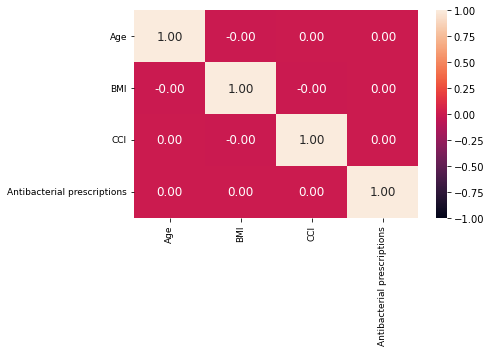

In [67]:
fig, ax = plt.subplots(figsize=(7, 5))
sns.heatmap(data_urti_combined[['age', 'bmi', 'CCI', 'antibacterial_brit']].corr(), 
            annot=True, fmt=".2f", annot_kws={"size":12},
            vmin=-1.0, vmax=1.0)

ax.set_xticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions'], rotation=90, fontsize=9)
ax.set_yticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions',], rotation=0, fontsize=9)                        
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_urti_combined/corr_urti_combined.jpg')
plt.show()

## 4- separate data of incident/prevalent and with/without antibiotics and stratified sub-datasets

In [68]:
data_urti_combined = data_urti_combined[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 
                                   'antibacterial_brit', 'urti_combined_ab_date', 'ab_type_cat', 'incdt_urti_combined_date', 'date', 'period',
                                   'event_urti_combined_admitted', 'duration_urti_combined_admitted'
                                    ]]

In [69]:
#switch variable urti_combined_ab_date into a binary variable
data_urti_combined[['ab_binary']] = data_urti_combined[['urti_combined_ab_date']].where(data_urti_combined[['urti_combined_ab_date']].isnull(), 1).fillna(0).astype(int)
#incident and prevalent infection 
data_urti_combined_incdt = data_urti_combined[data_urti_combined['incdt_urti_combined_date'] == 0]
data_urti_combined_prevl = data_urti_combined[data_urti_combined['incdt_urti_combined_date'] == 1]

#no antibiotics and incident hospital admission
data_urti_combined_no_abs_incdt = data_urti_combined_incdt[data_urti_combined_incdt['ab_binary'] == 0]
#with antibiotics and incident hospital admission
data_urti_combined_abs_incdt = data_urti_combined_incdt[data_urti_combined_incdt['ab_binary'] == 1]

#no antibiotics and prevalent hospital admission
data_urti_combined_no_abs_prevl = data_urti_combined_prevl[data_urti_combined_prevl['ab_binary'] == 0]
#with antibiotics and prevalent hospital admission
data_urti_combined_abs_prevl = data_urti_combined_prevl[data_urti_combined_prevl['ab_binary'] == 1]

In [70]:
##subcohorts for stratification by period
#incident and prevalent infection stratified by time period categories
data_urti_combined_incdt_prepandemic = data_urti_combined_incdt[data_urti_combined_incdt['period'] == 'prepandemic']
data_urti_combined_incdt_during_pandemic = data_urti_combined_incdt[(data_urti_combined_incdt['period'] == 'during_pandemic')]
data_urti_combined_incdt_post_2nd_lockdown = data_urti_combined_incdt[data_urti_combined_incdt['period'] == 'post_2nd_lockdown']
data_urti_combined_prevl_prepandemic = data_urti_combined_prevl[data_urti_combined_prevl['period'] == 'prepandemic']
data_urti_combined_prevl_during_pandemic = data_urti_combined_prevl[(data_urti_combined_prevl['period'] == 'during_pandemic')]
data_urti_combined_prevl_post_2nd_lockdown = data_urti_combined_prevl[data_urti_combined_prevl['period'] == 'post_2nd_lockdown']

#no antibiotics and incident hospital admission
data_urti_combined_no_abs_incdt_prepandemic = data_urti_combined_incdt_prepandemic[data_urti_combined_incdt_prepandemic['ab_binary'] == 0]
data_urti_combined_no_abs_incdt_during_pandemic = data_urti_combined_incdt_during_pandemic[data_urti_combined_incdt_during_pandemic['ab_binary'] == 0]
data_urti_combined_no_abs_incdt_post_2nd_lockdown = data_urti_combined_incdt_post_2nd_lockdown[data_urti_combined_incdt_post_2nd_lockdown['ab_binary'] == 0]
data_urti_combined_no_abs_prevl_prepandemic = data_urti_combined_prevl_prepandemic[data_urti_combined_prevl_prepandemic['ab_binary'] == 0]
data_urti_combined_no_abs_prevl_during_pandemic = data_urti_combined_prevl_during_pandemic[data_urti_combined_prevl_during_pandemic['ab_binary'] == 0]
data_urti_combined_no_abs_prevl_post_2nd_lockdown = data_urti_combined_prevl_post_2nd_lockdown[data_urti_combined_prevl_post_2nd_lockdown['ab_binary'] == 0]

In [71]:
#store data for plotting hosp admission counts and percentages
%store data_urti_combined
# save data
data_urti_combined.to_csv('../output/hospitalisation_prediction_urti_combined/data_urti_combined.csv')

Stored 'data_urti_combined' (DataFrame)


In [72]:
data_urti_combined_incdt

,age_cat,sex,CCI_cat,flu_vaccine,bmi_cat,region,imd,ethnicity,smoking_status,season,antibacterial_brit,urti_combined_ab_date,ab_type_cat,incdt_urti_combined_date,date,period,event_urti_combined_admitted,duration_urti_combined_admitted,ab_binary
1,75_more,male,medium,no,obese,london,unaffluent,white,smoker,spring,0.0,NaN,no,0,2022-04,post_2nd_lockdown,0.0,30.0,0
3,25_34,male,very_high,no,obese,west_midlands,unaffluent,white,unknown,winter,0.0,NaN,no,0,2021-01,during_pandemic,0.0,30.0,0
5,25_34,male,very_high,yes,unknown,west_midlands,very_affluent,white,unknown,autumn,4.0,NaN,no,0,2021-10,post_2nd_lockdown,0.0,30.0,0
8,15_24,male,low,no,healthy_weight,north_east,unaffluent,other,never_smoked,winter,0.0,NaN,no,0,2023-01,post_2nd_lockdown,0.0,30.0,0
10,75_more,female,very_high,no,obese,south_east,very_affluent,asian,never_smoked,spring,2.0,NaN,no,0,2019-05,prepandemic,0.0,30.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1439632,55_64,female,low,no,obese,east,very_unaffluent,white,unknown,winter,0.0,2019-10-30,other,0,2021-01,during_pandemic,0.0,30.0,1
1439637,75_more,female,low,no,obese,london,unaffluent,white,smoker,summer,2.0,NaN,no,0,2022-06,post_2nd_lockdown,0.0,30.0,0
1439639,55_64,male,low,no,overweight,london,unaffluent,unknown,unknown,spring,3.0,NaN,no,0,2022-05,post_2nd_lockdown,0.0,30.0,0
1439640,45_54,male,very_low,no,overweight,south_west,medium,unknown,never_smoked,summer,2.0,NaN,no,0,2021-08,post_2nd_lockdown,0.0,30.0,0


## 5- modelling of antibiotics prediction based on risk of hospital admission
### 5-1- incident

<lifelines.CoxPHFitter: fitted with 449963 total observations, 446878 right-censored observations>
             duration col = 'duration_urti_combined_admitted'
                event col = 'event_urti_combined_admitted'
      baseline estimation = breslow
   number of observations = 449963
number of events observed = 3085
   partial log-likelihood = -40128.71
         time fit was run = 2023-06-27 19:41:24 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.04       0.96       0.05            -0.15             0.06                 0.86                 1.07
CCI_cat[T.medium]                0.03       1.03       0.06            -0.09             0.14                 0.92                 1.15
CCI_cat[T.high]                  0.12       1.13       0.07            -0.01             0.26                 0.99                 1.29
CCI_cat[T.very_high]             0.04       1.04       0.06            -0.08             0.16                 0.92                 1.17
age_cat[T.25_34]                -0.03       0.97       0.07            -0.16             0.10                 0.86                 1.11
age_cat[T.35_44]                -0.07       0.93       0.07            -0.20             0.06                 0.82                 1.06
age_cat[T.45_54]                -0.08       0.93       0.07            -0.21             0.06                 0.81                 1.06
age_cat[T.55_64]                -0.07       0.93       0.07            -0.20             0.06                 0.82                 1.06
age_cat[T.65_74]                -0.05       0.95       0.07            -0.18             0.08                 0.84                 1.08
age_cat[T.75_more]              -0.12       0.89       0.07            -0.25             0.01                 0.78                 1.01
antibacterial_brit              -0.00       1.00       0.01            -0.03             0.02                 0.97                 1.02
bmi_cat[T.obese]                 0.01       1.01       0.07            -0.12             0.14                 0.88                 1.15
bmi_cat[T.overweight]            0.00       1.00       0.08            -0.16             0.17                 0.85                 1.18
bmi_cat[T.underweight]          -0.11       0.89       0.12            -0.35             0.13                 0.70                 1.14
bmi_cat[T.unknown]              -0.06       0.95       0.07            -0.20             0.09                 0.82                 1.09
ethnicity[T.other]               0.03       1.03       0.09            -0.15             0.21                 0.86                 1.24
ethnicity[T.unknown]             0.02       1.02       0.08            -0.13             0.17                 0.88                 1.18
ethnicity[T.white]               0.02       1.02       0.07            -0.12             0.16                 0.89                 1.17
flu_vaccine[T.yes]              -0.07       0.94       0.06            -0.19             0.06                 0.83                 1.06
imd[T.medium]                    0.00       1.00       0.06            -0.12             0.12                 0.89                 1.12
imd[T.unaffluent]               -0.00       1.00       0.06            -0.12             0.11                 0.89                 1.12
imd[T.unknown]                   0.11       1.11       0.09            -0.07             0.28                 0.94                 1.32
imd[T.very_affluent]             0.02       1.02       0.06            -0.10             0.13                 0.90                 1.14
imd[T.very_unaffluent]           0.08       1.08       0.06            -0.03             0.19                 0.97                 1.21
region[T.east_midlands]         -0.05       0

12249


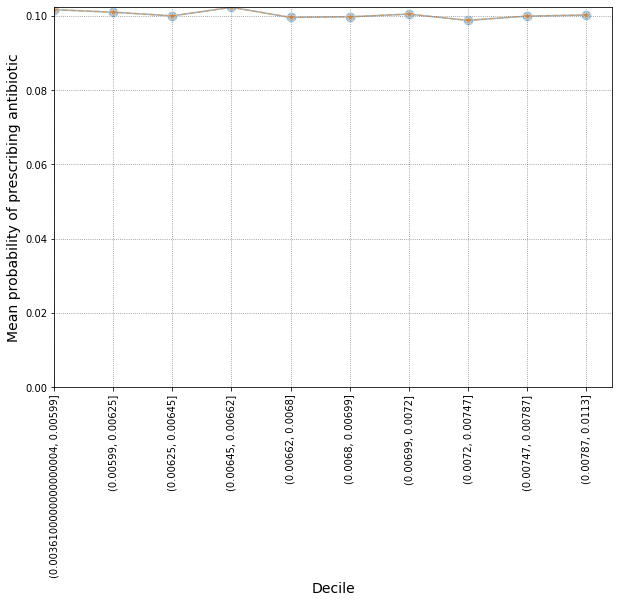


LR AUROC with development and validation data: 0.50774 and 0.50115
RF AUROC with development and validation data: 0.55582 and 0.50078
LR coefficients:
                                              OR  Lower CI  Upper CI
age_cat_15_24                          0.882840       NaN       NaN
age_cat_25_34                          0.893106       NaN       NaN
age_cat_35_44                          0.891808       NaN       NaN
age_cat_45_54                          0.895620       NaN       NaN
age_cat_55_64                          0.882226       NaN       NaN
age_cat_65_74                          0.890279       NaN       NaN
age_cat_75_more                        0.887948       NaN       NaN
sex_female                             0.658273       NaN       NaN
sex_male                               0.667218       NaN       NaN
CCI_cat_high                           0.840146       NaN       NaN
CCI_cat_low                            0.853954       NaN       NaN
CCI_cat_medium                 

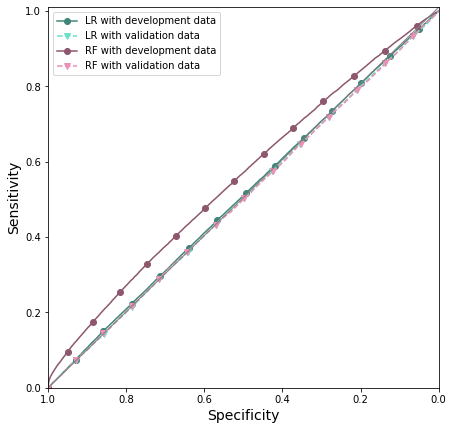

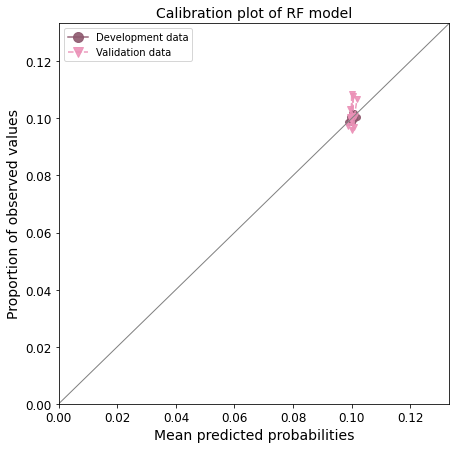

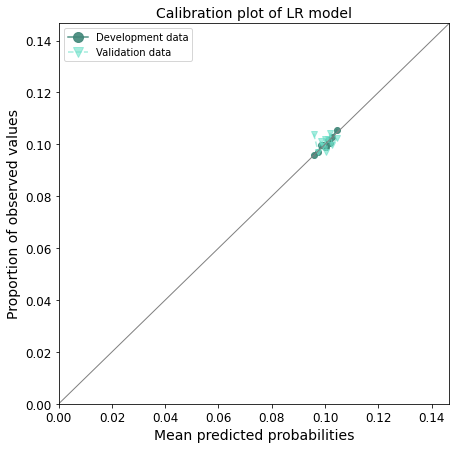

In [73]:
#build cox model for hosp prediction using non ab users' data
prob_pred_urti_combined_no_abs_incdt, prob_pred_urti_combined_no_abs_incdt_bin = cox_build('urti_combined', 'incdt', data_urti_combined_incdt, data_urti_combined_no_abs_incdt)

#build rf and lr models
prob_pred_enc_lr_rf_incdt, data_enc_dev_incdt, data_enc_val_incdt, lr_pred_dev_incdt, lr_pred_val_incdt, rf_pred_dev_incdt, rf_pred_val_incdt = lr_rf_build_risk('urti_combined', 'incdt', prob_pred_urti_combined_no_abs_incdt)

#make summary table
make_summary_table('urti_combined', 'incdt', prob_pred_enc_lr_rf_incdt)

#calibration plots of rf and lr
calibration_rf_lr('urti_combined', 'incdt', data_enc_dev_incdt, data_enc_val_incdt, lr_pred_dev_incdt, lr_pred_val_incdt, rf_pred_dev_incdt, rf_pred_val_incdt)

#### 5-2- prevalent

<lifelines.CoxPHFitter: fitted with 50038 total observations, 49667 right-censored observations>
             duration col = 'duration_urti_combined_admitted'
                event col = 'event_urti_combined_admitted'
      baseline estimation = breslow
   number of observations = 50038
number of events observed = 371
   partial log-likelihood = -3998.59
         time fit was run = 2023-06-27 19:43:55 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.16       0.85       0.15            -0.45             0.13                 0.64                 1.14
CCI_cat[T.medium]               -0.04       0.96       0.16            -0.36             0.27                 0.70                 1.31
CCI_cat[T.high]                 -0.31       0.73       0.21            -0.72             0.10                 0.49                 1.11
CCI_cat[T.very_high]            -0.29       0.75       0.18            -0.64             0.07                 0.53                 1.07
age_cat[T.25_34]                -0.03       0.97       0.19            -0.40             0.33                 0.67                 1.40
age_cat[T.35_44]                -0.08       0.93       0.19            -0.45             0.30                 0.64                 1.35
age_cat[T.45_54]                -0.15       0.86       0.19            -0.53             0.23                 0.59                 1.26
age_cat[T.55_64]                -0.07       0.93       0.19            -0.44             0.31                 0.64                 1.36
age_cat[T.65_74]                -0.15       0.86       0.19            -0.54             0.23                 0.59                 1.26
age_cat[T.75_more]              -0.09       0.92       0.19            -0.46             0.29                 0.63                 1.33
antibacterial_brit              -0.02       0.98       0.04            -0.10             0.05                 0.91                 1.05
bmi_cat[T.obese]                -0.19       0.83       0.18            -0.55             0.17                 0.58                 1.19
bmi_cat[T.overweight]           -0.36       0.70       0.24            -0.83             0.12                 0.44                 1.12
bmi_cat[T.underweight]          -0.16       0.85       0.33            -0.82             0.49                 0.44                 1.64
bmi_cat[T.unknown]              -0.04       0.96       0.20            -0.42             0.35                 0.66                 1.41
ethnicity[T.other]               0.53       1.70       0.28            -0.02             1.08                 0.98                 2.96
ethnicity[T.unknown]             0.41       1.50       0.25            -0.07             0.89                 0.93                 2.43
ethnicity[T.white]               0.33       1.39       0.23            -0.13             0.78                 0.88                 2.19
flu_vaccine[T.yes]               0.14       1.15       0.16            -0.19             0.46                 0.83                 1.58
imd[T.medium]                    0.03       1.03       0.17            -0.30             0.37                 0.74                 1.45
imd[T.unaffluent]               -0.09       0.92       0.18            -0.43             0.26                 0.65                 1.29
imd[T.unknown]                   0.22       1.25       0.25            -0.26             0.70                 0.77                 2.02
imd[T.very_affluent]             0.17       1.18       0.17            -0.16             0.49                 0.85                 1.63
imd[T.very_unaffluent]           0.01       1.01       0.17            -0.33             0.34                 0.72                 1.41
region[T.east_midlands]         -0.03       0.97  

12259


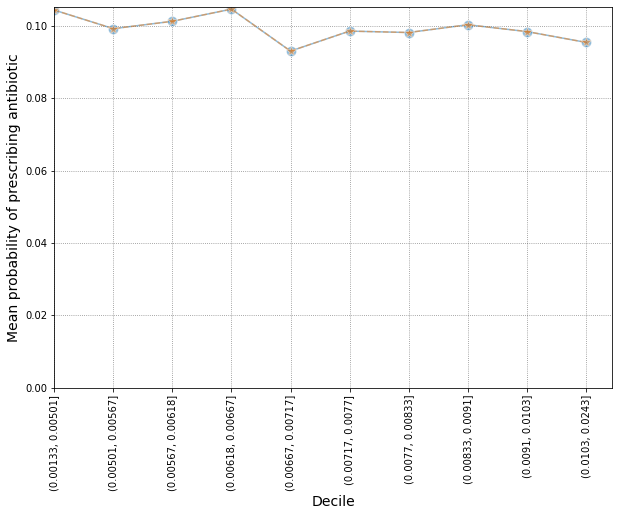


LR AUROC with development and validation data: 0.53095 and 0.50994
RF AUROC with development and validation data: 0.66974 and 0.50906
LR coefficients:
                                    OR  Lower CI  Upper CI
age_cat_15_24                0.893251       NaN       NaN
age_cat_25_34                0.806530       NaN       NaN
age_cat_35_44                0.872130       NaN       NaN
age_cat_45_54                0.866951       NaN       NaN
age_cat_55_64                0.925575       NaN       NaN
age_cat_65_74                0.910982       NaN       NaN
age_cat_75_more              0.940894       NaN       NaN
sex_female                   0.631993       NaN       NaN
sex_male                     0.683785       NaN       NaN
CCI_cat_high                 0.894596       NaN       NaN
CCI_cat_low                  0.819545  0.000000       inf
CCI_cat_medium               0.790930       NaN       NaN
CCI_cat_very_high            0.896290  0.000000       inf
CCI_cat_very_low             0.8314

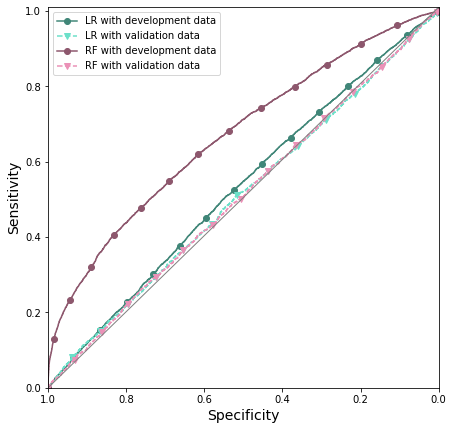

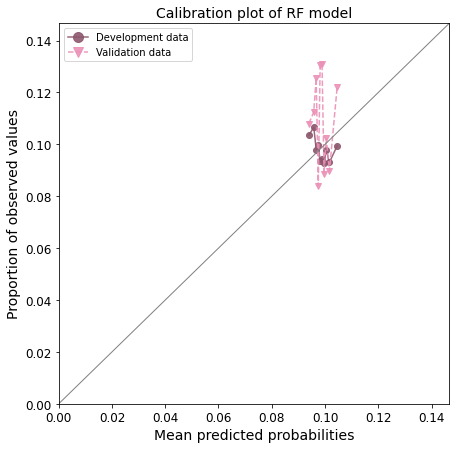

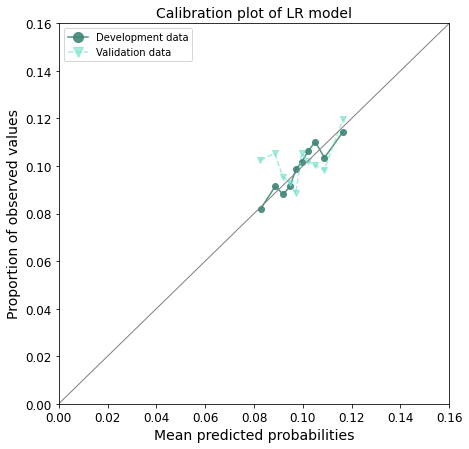

In [74]:
#build cox model for hosp prediction using non ab users' data
prob_pred_urti_combined_no_abs_prevl, prob_pred_urti_combined_no_abs_prevl_bin = cox_build('urti_combined', 'prevl', data_urti_combined_prevl, data_urti_combined_no_abs_prevl)

#build rf and lr models
prob_pred_enc_lr_rf_prevl, data_enc_dev_prevl, data_enc_val_prevl, lr_pred_dev_prevl, lr_pred_val_prevl, rf_pred_dev_prevl, rf_pred_val_prevl = lr_rf_build_risk('urti_combined', 'prevl', prob_pred_urti_combined_no_abs_prevl)

#make summary table
make_summary_table('urti_combined', 'prevl', prob_pred_enc_lr_rf_prevl)

#calibration plots of rf and lr
calibration_rf_lr('urti_combined', 'prevl', data_enc_dev_prevl, data_enc_val_prevl, lr_pred_dev_prevl, lr_pred_val_prevl, rf_pred_dev_prevl, rf_pred_val_prevl)

#### 5-3- stratification by time period
#### 5-3-1- incident

<lifelines.CoxPHFitter: fitted with 123862 total observations, 123100 right-censored observations>
             duration col = 'duration_urti_combined_admitted'
                event col = 'event_urti_combined_admitted'
      baseline estimation = breslow
   number of observations = 123862
number of events observed = 762
   partial log-likelihood = -8909.62
         time fit was run = 2023-06-27 19:44:08 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.15       0.86       0.11            -0.37             0.06                 0.69                 1.06
CCI_cat[T.medium]                0.05       1.05       0.12            -0.18             0.28                 0.84                 1.32
CCI_cat[T.high]                  0.04       1.04       0.14            -0.24             0.31                 0.79                 1.36
CCI_cat[T.very_high]             0.05       1.05       0.12            -0.19             0.29                 0.83                 1.34
age_cat[T.25_34]                -0.22       0.80       0.14            -0.49             0.05                 0.61                 1.05
age_cat[T.35_44]                -0.07       0.94       0.13            -0.32             0.19                 0.73                 1.21
age_cat[T.45_54]                -0.35       0.70       0.14            -0.63            -0.08                 0.53                 0.92
age_cat[T.55_64]                -0.03       0.97       0.13            -0.28             0.22                 0.75                 1.25
age_cat[T.65_74]                 0.04       1.04       0.13            -0.21             0.29                 0.81                 1.33
age_cat[T.75_more]              -0.21       0.81       0.14            -0.47             0.06                 0.62                 1.06
antibacterial_brit              -0.00       1.00       0.03            -0.06             0.05                 0.95                 1.05
bmi_cat[T.obese]                 0.00       1.00       0.14            -0.27             0.27                 0.77                 1.31
bmi_cat[T.overweight]           -0.06       0.94       0.17            -0.39             0.27                 0.67                 1.31
bmi_cat[T.underweight]          -0.06       0.94       0.24            -0.54             0.42                 0.58                 1.52
bmi_cat[T.unknown]               0.04       1.04       0.15            -0.24             0.33                 0.78                 1.39
ethnicity[T.other]              -0.09       0.92       0.19            -0.47             0.29                 0.63                 1.34
ethnicity[T.unknown]             0.14       1.15       0.15            -0.16             0.44                 0.85                 1.55
ethnicity[T.white]               0.02       1.02       0.14            -0.26             0.30                 0.77                 1.35
flu_vaccine[T.yes]               0.07       1.08       0.12            -0.16             0.30                 0.85                 1.35
imd[T.medium]                    0.00       1.00       0.11            -0.22             0.22                 0.80                 1.25
imd[T.unaffluent]                0.03       1.03       0.11            -0.20             0.25                 0.82                 1.28
imd[T.unknown]                  -0.32       0.73       0.20            -0.71             0.07                 0.49                 1.08
imd[T.very_affluent]            -0.14       0.87       0.12            -0.37             0.09                 0.69                 1.10
imd[T.very_unaffluent]          -0.19       0.82       0.12            -0.43             0.04                 0.65                 1.04
region[T.east_midlands]         -0.13       0.8

12246


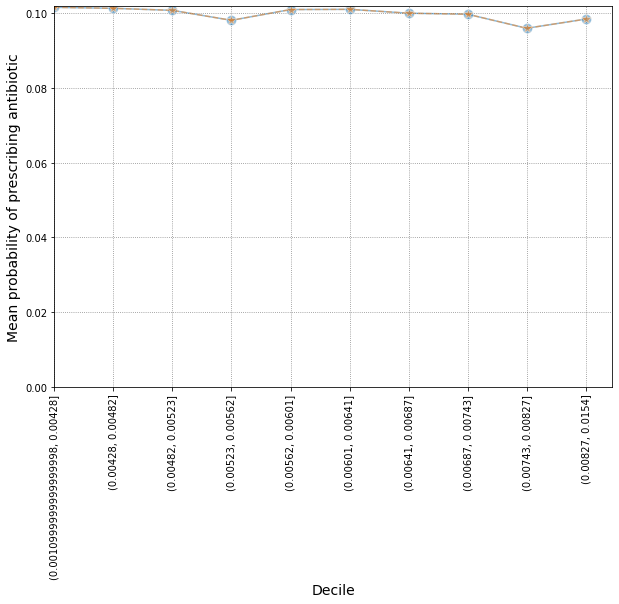


LR AUROC with development and validation data: 0.51590 and 0.50288
RF AUROC with development and validation data: 0.60556 and 0.49977
LR coefficients:
                                              OR  Lower CI  Upper CI
age_cat_15_24                          0.920901       NaN       NaN
age_cat_25_34                          0.829207       NaN       NaN
age_cat_35_44                          0.902664       NaN       NaN
age_cat_45_54                          0.845234       NaN       NaN
age_cat_55_64                          0.940134       NaN       NaN
age_cat_65_74                          0.939647       NaN       NaN
age_cat_75_more                        0.859673       NaN       NaN
sex_female                             0.663324       NaN       NaN
sex_male                               0.667024       NaN       NaN
CCI_cat_high                           0.856387       NaN       NaN
CCI_cat_low                            0.792759       NaN       NaN
CCI_cat_medium                 

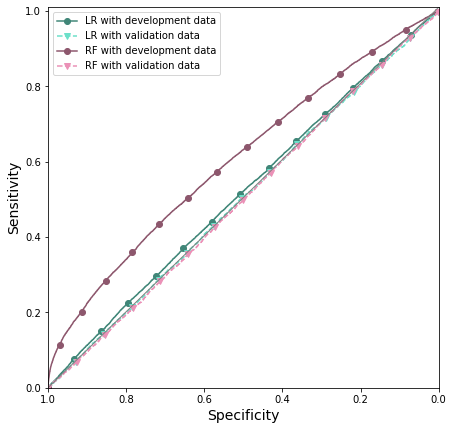

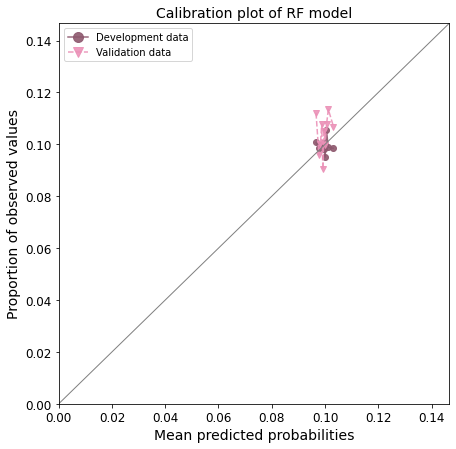

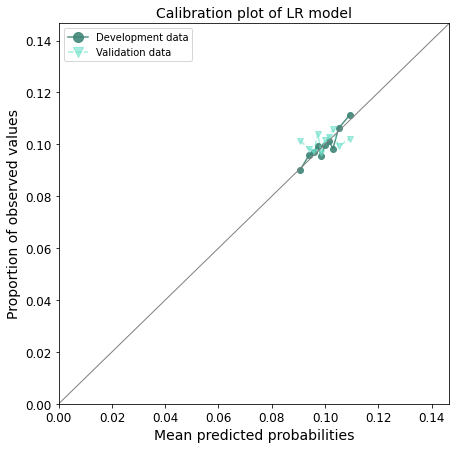

In [75]:
#build cox model for hosp prediction using non ab users' data
prob_pred_urti_combined_no_abs_incdt_prepandemic, prob_pred_urti_combined_no_abs_incdt_prepandemic_bin = cox_build('urti_combined', 'incdt_prepandemic', data_urti_combined_incdt_prepandemic, data_urti_combined_no_abs_incdt_prepandemic)

#build rf and lr models
prob_pred_enc_lr_rf_incdt_prepandemic, data_enc_dev_incdt_prepandemic, data_enc_val_incdt_prepandemic, lr_pred_dev_incdt_prepandemic, lr_pred_val_incdt_prepandemic, rf_pred_dev_incdt_prepandemic, rf_pred_val_incdt_prepandemic = lr_rf_build_risk('urti_combined', 'incdt_prepandemic', prob_pred_urti_combined_no_abs_incdt_prepandemic)

#calibration plots of rf and lr
calibration_rf_lr('urti_combined', 'incdt_prepandemic', data_enc_dev_incdt_prepandemic, data_enc_val_incdt_prepandemic, lr_pred_dev_incdt_prepandemic, lr_pred_val_incdt_prepandemic, rf_pred_dev_incdt_prepandemic, rf_pred_val_incdt_prepandemic)

<lifelines.CoxPHFitter: fitted with 142680 total observations, 141751 right-censored observations>
             duration col = 'duration_urti_combined_admitted'
                event col = 'event_urti_combined_admitted'
      baseline estimation = breslow
   number of observations = 142680
number of events observed = 929
   partial log-likelihood = -11009.23
         time fit was run = 2023-06-27 19:44:37 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.09       0.92       0.10            -0.28             0.10                 0.76                 1.11
CCI_cat[T.medium]               -0.00       1.00       0.11            -0.21             0.21                 0.81                 1.23
CCI_cat[T.high]                  0.12       1.13       0.12            -0.12             0.36                 0.89                 1.44
CCI_cat[T.very_high]            -0.05       0.95       0.11            -0.27             0.17                 0.76                 1.19
age_cat[T.25_34]                 0.02       1.02       0.12            -0.22             0.26                 0.80                 1.30
age_cat[T.35_44]                 0.03       1.03       0.12            -0.21             0.27                 0.81                 1.31
age_cat[T.45_54]                 0.16       1.18       0.12            -0.07             0.40                 0.93                 1.49
age_cat[T.55_64]                 0.05       1.05       0.12            -0.19             0.29                 0.82                 1.33
age_cat[T.65_74]                 0.01       1.01       0.12            -0.23             0.25                 0.79                 1.29
age_cat[T.75_more]              -0.05       0.95       0.13            -0.30             0.19                 0.74                 1.21
antibacterial_brit              -0.02       0.98       0.02            -0.06             0.03                 0.94                 1.03
bmi_cat[T.obese]                -0.10       0.90       0.12            -0.33             0.13                 0.72                 1.14
bmi_cat[T.overweight]           -0.19       0.82       0.15            -0.48             0.10                 0.62                 1.10
bmi_cat[T.underweight]          -0.24       0.79       0.22            -0.67             0.19                 0.51                 1.21
bmi_cat[T.unknown]              -0.17       0.84       0.13            -0.42             0.08                 0.66                 1.08
ethnicity[T.other]              -0.22       0.80       0.18            -0.58             0.13                 0.56                 1.14
ethnicity[T.unknown]            -0.02       0.98       0.14            -0.29             0.25                 0.75                 1.29
ethnicity[T.white]               0.06       1.06       0.13            -0.19             0.31                 0.82                 1.36
flu_vaccine[T.yes]              -0.12       0.89       0.12            -0.35             0.10                 0.71                 1.11
imd[T.medium]                   -0.11       0.90       0.11            -0.32             0.10                 0.73                 1.11
imd[T.unaffluent]               -0.09       0.92       0.11            -0.30             0.12                 0.74                 1.13
imd[T.unknown]                   0.12       1.12       0.15            -0.19             0.42                 0.83                 1.52
imd[T.very_affluent]            -0.06       0.94       0.11            -0.27             0.15                 0.76                 1.16
imd[T.very_unaffluent]           0.05       1.05       0.10            -0.16             0.25                 0.86                 1.29
region[T.east_midlands]          0.01       1.

12248


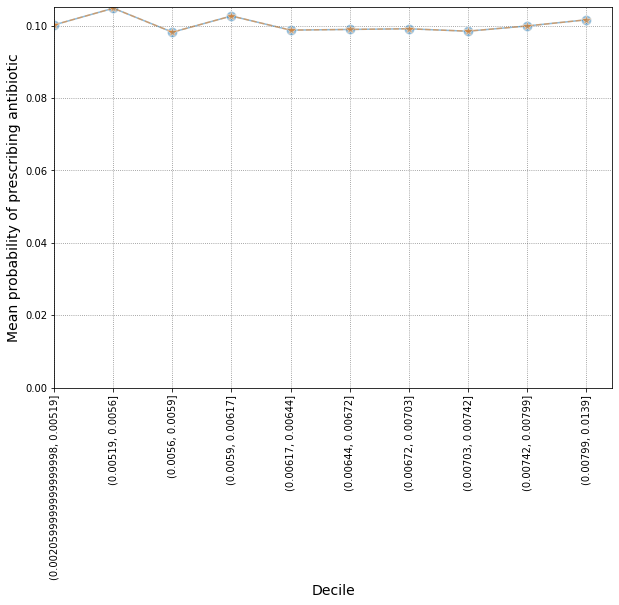


LR AUROC with development and validation data: 0.51534 and 0.50578
RF AUROC with development and validation data: 0.60715 and 0.50425
LR coefficients:
                                              OR  Lower CI  Upper CI
age_cat_15_24                          0.889434       NaN       NaN
age_cat_25_34                          0.921558       NaN       NaN
age_cat_35_44                          0.892125       NaN       NaN
age_cat_45_54                          0.870900       NaN       NaN
age_cat_55_64                          0.838386       NaN       NaN
age_cat_65_74                          0.891284       NaN       NaN
age_cat_75_more                        0.923442       NaN       NaN
sex_female                             0.659924       NaN       NaN
sex_male                               0.665896       NaN       NaN
CCI_cat_high                           0.826211       NaN       NaN
CCI_cat_low                            0.870779       NaN       NaN
CCI_cat_medium                 

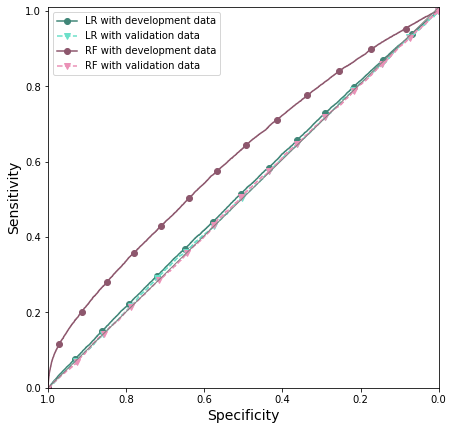

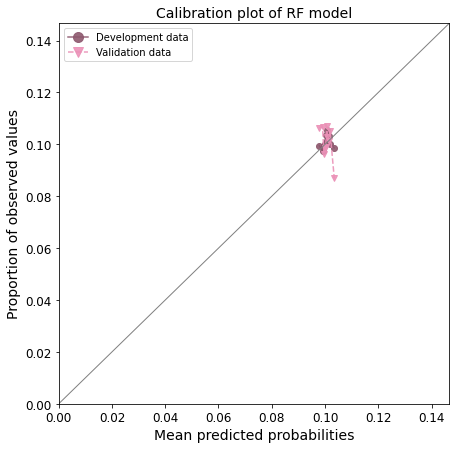

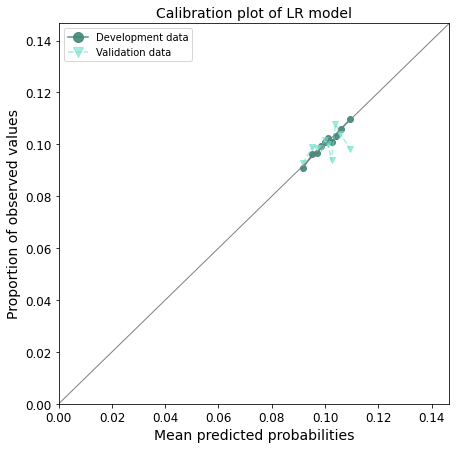

In [76]:
#build cox model for hosp prediction using non ab users' data
prob_pred_urti_combined_no_abs_incdt_during_pandemic, prob_pred_urti_combined_no_abs_incdt_during_pandemic_bin = cox_build('urti_combined', 'incdt_during_pandemic', data_urti_combined_incdt_during_pandemic, data_urti_combined_no_abs_incdt_during_pandemic)

#build rf and lr models
prob_pred_enc_lr_rf_incdt_during_pandemic, data_enc_dev_incdt_during_pandemic, data_enc_val_incdt_during_pandemic, lr_pred_dev_incdt_during_pandemic, lr_pred_val_incdt_during_pandemic, rf_pred_dev_incdt_during_pandemic, rf_pred_val_incdt_during_pandemic = lr_rf_build_risk('urti_combined', 'incdt_during_pandemic', prob_pred_urti_combined_no_abs_incdt_during_pandemic)

#calibration plots of rf and lr
calibration_rf_lr('urti_combined', 'incdt_during_pandemic', data_enc_dev_incdt_during_pandemic, data_enc_val_incdt_during_pandemic, lr_pred_dev_incdt_during_pandemic, lr_pred_val_incdt_during_pandemic, rf_pred_dev_incdt_during_pandemic, rf_pred_val_incdt_during_pandemic)

<lifelines.CoxPHFitter: fitted with 183420 total observations, 182079 right-censored observations>
             duration col = 'duration_urti_combined_admitted'
                event col = 'event_urti_combined_admitted'
      baseline estimation = breslow
   number of observations = 183420
number of events observed = 1341
   partial log-likelihood = -16224.53
         time fit was run = 2023-06-27 19:45:15 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.03       1.03       0.08            -0.13             0.20                 0.88                 1.22
CCI_cat[T.medium]                0.06       1.06       0.09            -0.12             0.24                 0.89                 1.27
CCI_cat[T.high]                  0.12       1.13       0.11            -0.08             0.33                 0.92                 1.39
CCI_cat[T.very_high]             0.03       1.03       0.10            -0.16             0.21                 0.85                 1.24
age_cat[T.25_34]                 0.18       1.20       0.10            -0.02             0.38                 0.98                 1.46
age_cat[T.35_44]                 0.08       1.09       0.10            -0.12             0.29                 0.89                 1.33
age_cat[T.45_54]                 0.09       1.09       0.10            -0.12             0.29                 0.89                 1.34
age_cat[T.55_64]                 0.06       1.06       0.10            -0.14             0.27                 0.87                 1.31
age_cat[T.65_74]                 0.06       1.06       0.10            -0.15             0.26                 0.86                 1.30
age_cat[T.75_more]               0.02       1.02       0.11            -0.19             0.23                 0.83                 1.25
antibacterial_brit               0.02       1.02       0.02            -0.02             0.06                 0.98                 1.06
bmi_cat[T.obese]                 0.14       1.15       0.11            -0.06             0.35                 0.94                 1.42
bmi_cat[T.overweight]            0.08       1.08       0.13            -0.17             0.33                 0.84                 1.39
bmi_cat[T.underweight]          -0.15       0.86       0.20            -0.54             0.23                 0.58                 1.26
bmi_cat[T.unknown]              -0.01       0.99       0.11            -0.23             0.21                 0.79                 1.24
ethnicity[T.other]               0.21       1.23       0.14            -0.07             0.48                 0.93                 1.62
ethnicity[T.unknown]             0.11       1.12       0.12            -0.11             0.34                 0.89                 1.41
ethnicity[T.white]               0.06       1.06       0.11            -0.16             0.27                 0.86                 1.31
flu_vaccine[T.yes]              -0.04       0.96       0.09            -0.22             0.14                 0.80                 1.15
imd[T.medium]                    0.12       1.13       0.09            -0.07             0.30                 0.94                 1.35
imd[T.unaffluent]                0.22       1.25       0.09             0.04             0.40                 1.05                 1.50
imd[T.unknown]                   0.17       1.18       0.14            -0.11             0.44                 0.90                 1.56
imd[T.very_affluent]             0.22       1.25       0.09             0.04             0.40                 1.04                 1.49
imd[T.very_unaffluent]           0.27       1.31       0.09             0.09             0.45                 1.10                 1.57
region[T.east_midlands]         -0.15       0

12232


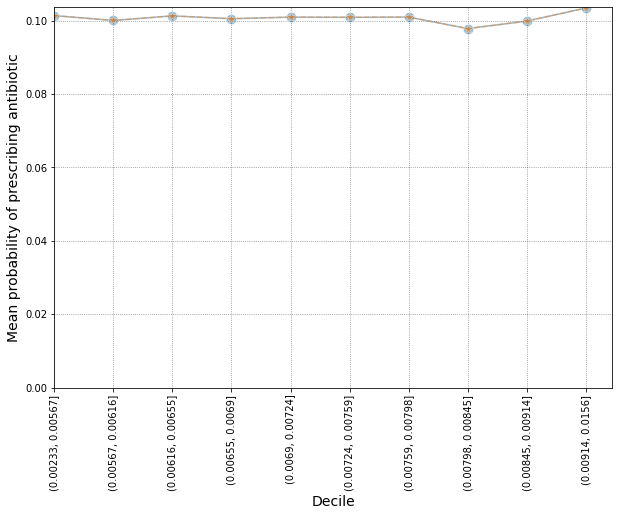


LR AUROC with development and validation data: 0.51380 and 0.49632
RF AUROC with development and validation data: 0.58968 and 0.49988
LR coefficients:
                                    OR  Lower CI  Upper CI
age_cat_15_24                0.889732  0.000000       inf
age_cat_25_34                0.873278  0.000000       inf
age_cat_35_44                0.878698  0.000000       inf
age_cat_45_54                0.893427  0.000000       inf
age_cat_55_64                0.909629  0.000000       inf
age_cat_65_74                0.895961  0.000000       inf
age_cat_75_more              0.889003  0.000000       inf
sex_female                   0.660571       NaN       NaN
sex_male                     0.669033       NaN       NaN
CCI_cat_high                 0.820220  0.000000       inf
CCI_cat_low                  0.845980  0.000000       inf
CCI_cat_medium               0.860028  0.000000       inf
CCI_cat_very_high            0.868347  0.000000       inf
CCI_cat_very_low             0.8528

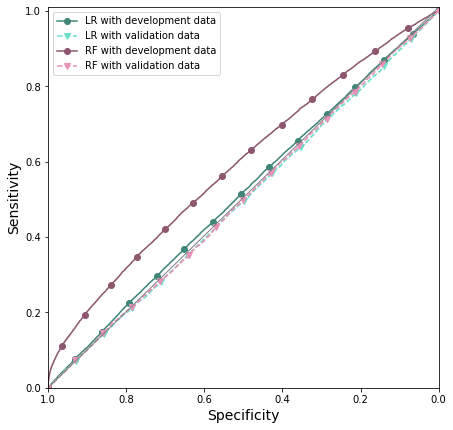

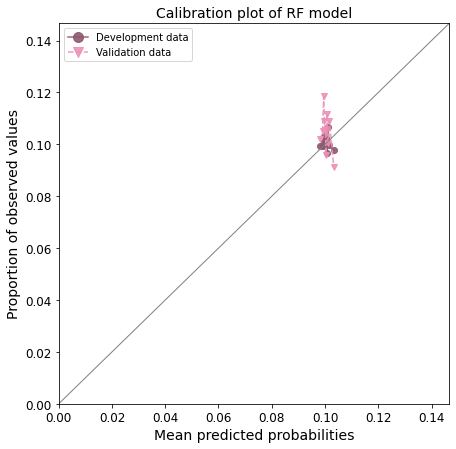

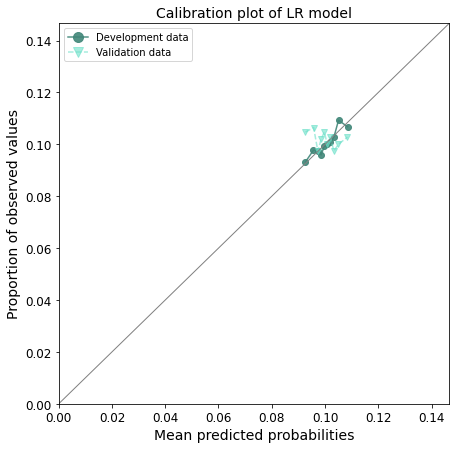

In [77]:
#build cox model for hosp prediction using non ab users' data
prob_pred_urti_combined_no_abs_incdt_post_2nd_lockdown, prob_pred_urti_combined_no_abs_incdt_post_2nd_lockdown_bin = cox_build('urti_combined', 'incdt_post_2nd_lockdown', data_urti_combined_incdt_post_2nd_lockdown, data_urti_combined_no_abs_incdt_post_2nd_lockdown)

#build rf and lr models
prob_pred_enc_lr_rf_incdt_post_2nd_lockdown, data_enc_dev_incdt_post_2nd_lockdown, data_enc_val_incdt_post_2nd_lockdown, lr_pred_dev_incdt_post_2nd_lockdown, lr_pred_val_incdt_post_2nd_lockdown, rf_pred_dev_incdt_post_2nd_lockdown, rf_pred_val_incdt_post_2nd_lockdown = lr_rf_build_risk('urti_combined', 'incdt_post_2nd_lockdown', prob_pred_urti_combined_no_abs_incdt_post_2nd_lockdown)

#calibration plots of rf and lr
calibration_rf_lr('urti_combined', 'incdt_post_2nd_lockdown', data_enc_dev_incdt_post_2nd_lockdown, data_enc_val_incdt_post_2nd_lockdown, lr_pred_dev_incdt_post_2nd_lockdown, lr_pred_val_incdt_post_2nd_lockdown, rf_pred_dev_incdt_post_2nd_lockdown, rf_pred_val_incdt_post_2nd_lockdown)

#### 5-3-2- prevalent

<lifelines.CoxPHFitter: fitted with 13799 total observations, 13721 right-censored observations>
             duration col = 'duration_urti_combined_admitted'
                event col = 'event_urti_combined_admitted'
      baseline estimation = breslow
   number of observations = 13799
number of events observed = 78
   partial log-likelihood = -728.68
         time fit was run = 2023-06-27 19:46:11 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.01       1.01       0.34            -0.64             0.67                 0.53                 1.96
CCI_cat[T.medium]                0.27       1.31       0.35            -0.42             0.97                 0.66                 2.63
CCI_cat[T.high]                 -0.29       0.75       0.49            -1.25             0.68                 0.29                 1.98
CCI_cat[T.very_high]            -0.27       0.76       0.42            -1.10             0.55                 0.33                 1.74
age_cat[T.25_34]                -0.15       0.86       0.39            -0.93             0.62                 0.40                 1.86
age_cat[T.35_44]                -0.43       0.65       0.43            -1.27             0.41                 0.28                 1.50
age_cat[T.45_54]                -0.24       0.79       0.40            -1.03             0.55                 0.36                 1.74
age_cat[T.55_64]                -0.17       0.84       0.39            -0.95             0.60                 0.39                 1.82
age_cat[T.65_74]                -0.48       0.62       0.43            -1.32             0.36                 0.27                 1.43
age_cat[T.75_more]              -0.24       0.79       0.40            -1.03             0.55                 0.36                 1.73
antibacterial_brit               0.04       1.04       0.08            -0.11             0.20                 0.90                 1.22
bmi_cat[T.obese]                -0.16       0.86       0.39            -0.91             0.60                 0.40                 1.83
bmi_cat[T.overweight]           -0.48       0.62       0.52            -1.49             0.54                 0.22                 1.71
bmi_cat[T.underweight]           0.31       1.36       0.61            -0.90             1.51                 0.41                 4.53
bmi_cat[T.unknown]              -0.40       0.67       0.43            -1.24             0.44                 0.29                 1.56
ethnicity[T.other]               0.31       1.36       0.59            -0.84             1.46                 0.43                 4.30
ethnicity[T.unknown]             0.21       1.23       0.50            -0.78             1.19                 0.46                 3.28
ethnicity[T.white]               0.13       1.14       0.47            -0.80             1.05                 0.45                 2.86
flu_vaccine[T.yes]              -0.31       0.74       0.43            -1.14             0.53                 0.32                 1.69
imd[T.medium]                    0.42       1.53       0.41            -0.38             1.22                 0.68                 3.40
imd[T.unaffluent]                0.47       1.60       0.40            -0.32             1.26                 0.72                 3.52
imd[T.unknown]                   0.23       1.25       0.66            -1.07             1.52                 0.34                 4.57
imd[T.very_affluent]             0.75       2.12       0.38             0.00             1.50                 1.00                 4.49
imd[T.very_unaffluent]           0.15       1.16       0.43            -0.69             0.99                 0.50                 2.68
region[T.east_midlands]          0.72       2.06    

12230


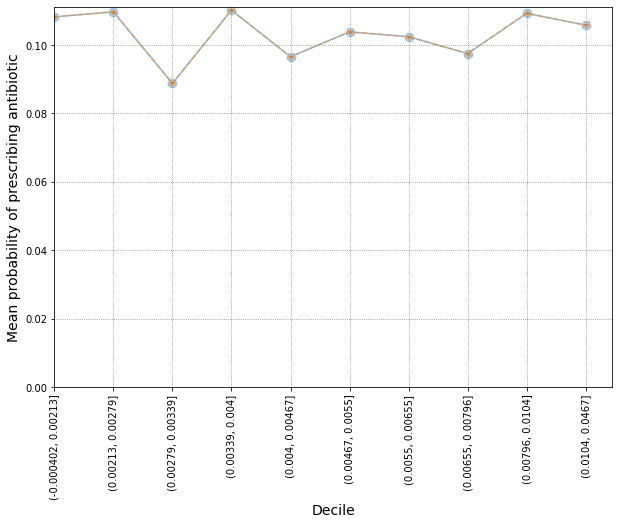


LR AUROC with development and validation data: 0.55712 and 0.49303
RF AUROC with development and validation data: 0.78387 and 0.49526
LR coefficients:
                                    OR  Lower CI  Upper CI
age_cat_15_24                0.854309  0.000000       inf
age_cat_25_34                0.885305  0.000000       inf
age_cat_35_44                0.936992  0.000000       inf
age_cat_45_54                0.941823  0.000000       inf
age_cat_55_64                0.974772  0.000000       inf
age_cat_65_74                0.740731  0.000000       inf
age_cat_75_more              0.901856  0.000000       inf
sex_female                   0.626125  0.000000       inf
sex_male                     0.694150  0.000000       inf
CCI_cat_high                 0.900900  0.000000       inf
CCI_cat_low                  0.791187  0.000000       inf
CCI_cat_medium               0.810450  0.000000       inf
CCI_cat_very_high            0.865163  0.000000       inf
CCI_cat_very_low             0.8696

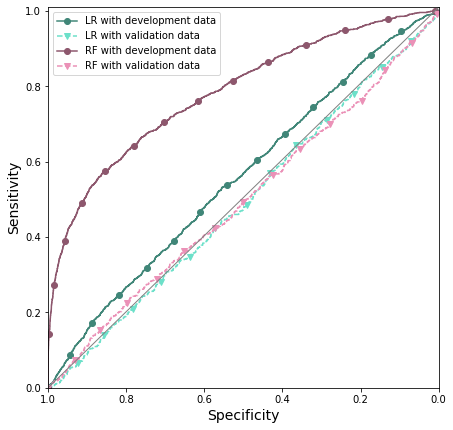

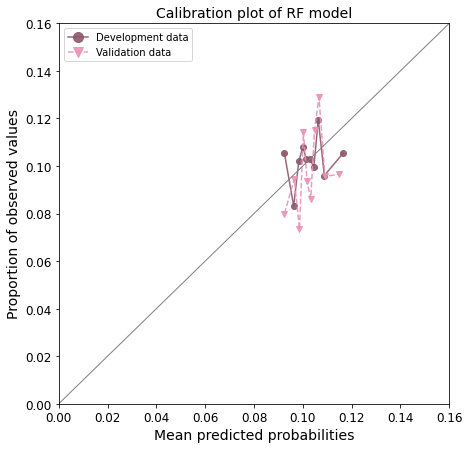

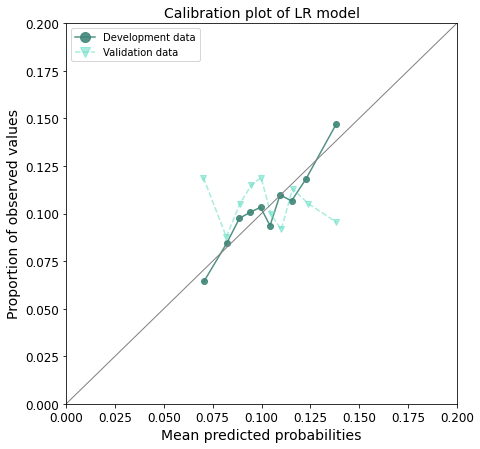

In [78]:
#build cox model for hosp prediction using non ab users' data
prob_pred_urti_combined_no_abs_prevl_prepandemic, prob_pred_urti_combined_no_abs_prevl_prepandemic_bin = cox_build('urti_combined', 'prevl_prepandemic', data_urti_combined_prevl_prepandemic, data_urti_combined_no_abs_prevl_prepandemic)

#build rf and lr models
prob_pred_enc_lr_rf_prevl_prepandemic, data_enc_dev_prevl_prepandemic, data_enc_val_prevl_prepandemic, lr_pred_dev_prevl_prepandemic, lr_pred_val_prevl_prepandemic, rf_pred_dev_prevl_prepandemic, rf_pred_val_prevl_prepandemic = lr_rf_build_risk('urti_combined', 'prevl_prepandemic', prob_pred_urti_combined_no_abs_prevl_prepandemic)

#calibration plots of rf and lr
calibration_rf_lr('urti_combined', 'prevl_prepandemic', data_enc_dev_prevl_prepandemic, data_enc_val_prevl_prepandemic, lr_pred_dev_prevl_prepandemic, lr_pred_val_prevl_prepandemic, rf_pred_dev_prevl_prepandemic, rf_pred_val_prevl_prepandemic)

<lifelines.CoxPHFitter: fitted with 16005 total observations, 15878 right-censored observations>
             duration col = 'duration_urti_combined_admitted'
                event col = 'event_urti_combined_admitted'
      baseline estimation = breslow
   number of observations = 16005
number of events observed = 127
   partial log-likelihood = -1210.89
         time fit was run = 2023-06-27 19:46:26 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.23       0.79       0.27            -0.76             0.30                 0.47                 1.35
CCI_cat[T.medium]                0.17       1.18       0.28            -0.37             0.71                 0.69                 2.03
CCI_cat[T.high]                  0.11       1.11       0.34            -0.55             0.76                 0.58                 2.14
CCI_cat[T.very_high]            -0.09       0.91       0.31            -0.70             0.51                 0.50                 1.67
age_cat[T.25_34]                 0.48       1.61       0.36            -0.22             1.18                 0.80                 3.24
age_cat[T.35_44]                 0.03       1.03       0.39            -0.74             0.80                 0.48                 2.22
age_cat[T.45_54]                 0.58       1.78       0.35            -0.10             1.26                 0.90                 3.52
age_cat[T.55_64]                 0.49       1.63       0.35            -0.20             1.18                 0.82                 3.26
age_cat[T.65_74]                 0.16       1.17       0.38            -0.59             0.90                 0.56                 2.46
age_cat[T.75_more]               0.56       1.75       0.35            -0.12             1.25                 0.88                 3.48
antibacterial_brit               0.03       1.03       0.06            -0.09             0.15                 0.91                 1.17
bmi_cat[T.obese]                 0.11       1.12       0.36            -0.58             0.81                 0.56                 2.25
bmi_cat[T.overweight]            0.10       1.11       0.43            -0.73             0.94                 0.48                 2.57
bmi_cat[T.underweight]          -0.55       0.58       0.78            -2.08             0.98                 0.12                 2.67
bmi_cat[T.unknown]               0.19       1.20       0.37            -0.55             0.92                 0.58                 2.50
ethnicity[T.other]               1.42       4.15       0.65             0.16             2.69                 1.17                14.72
ethnicity[T.unknown]             1.26       3.51       0.60             0.08             2.44                 1.08                11.45
ethnicity[T.white]               1.24       3.45       0.59             0.08             2.39                 1.09                10.93
flu_vaccine[T.yes]               0.08       1.08       0.28            -0.48             0.64                 0.62                 1.89
imd[T.medium]                   -0.01       0.99       0.30            -0.59             0.57                 0.55                 1.76
imd[T.unaffluent]                0.11       1.11       0.29            -0.46             0.67                 0.63                 1.95
imd[T.unknown]                  -0.44       0.64       0.54            -1.50             0.62                 0.22                 1.86
imd[T.very_affluent]             0.15       1.16       0.28            -0.40             0.71                 0.67                 2.03
imd[T.very_unaffluent]           0.00       1.00       0.29            -0.57             0.58                 0.57                 1.78
region[T.east_midlands]          0.04       1.04  

12232


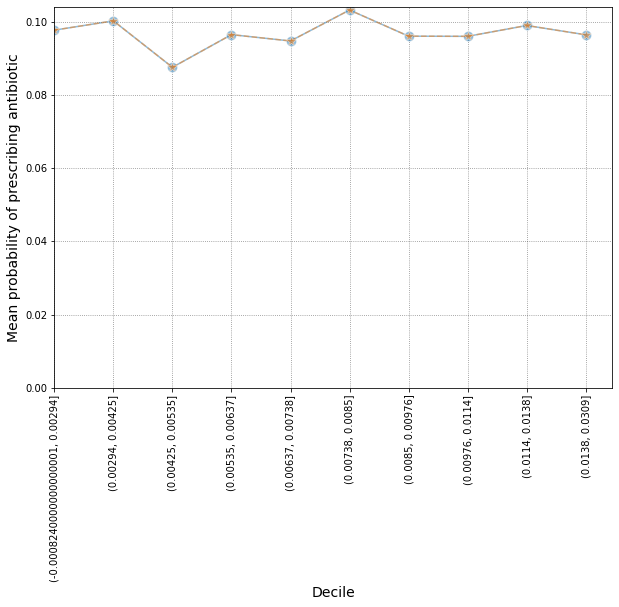


LR AUROC with development and validation data: 0.55711 and 0.49477
RF AUROC with development and validation data: 0.76416 and 0.49510
LR coefficients:
                                               OR  Lower CI  Upper CI
age_cat_15_24                           1.027782       NaN       NaN
age_cat_25_34                           0.806495       NaN       NaN
age_cat_35_44                           0.855431       NaN       NaN
age_cat_45_54                           0.842283       NaN       NaN
age_cat_55_64                           0.945262       NaN       NaN
age_cat_65_74                           0.836649       NaN       NaN
age_cat_75_more                         0.922350       NaN       NaN
sex_female                              0.608790  0.000000       inf
sex_male                                0.715598  0.000000       inf
CCI_cat_high                            0.805700       NaN       NaN
CCI_cat_low                             0.825568       NaN       NaN
CCI_cat_medium     

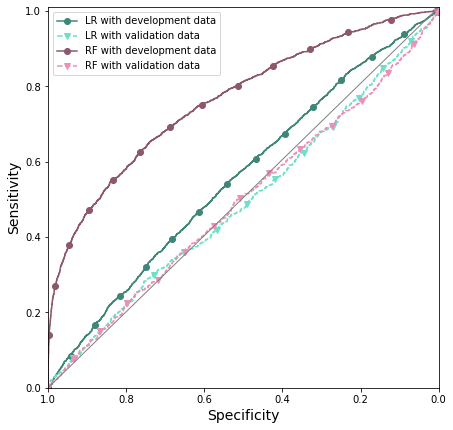

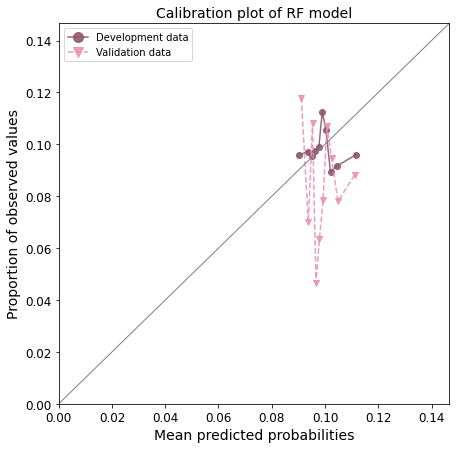

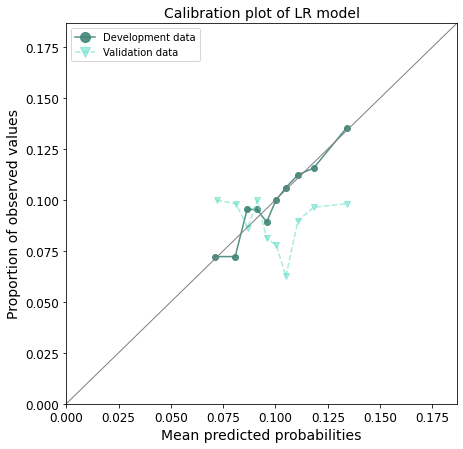

In [79]:
#build cox model for hosp prediction using non ab users' data
prob_pred_urti_combined_no_abs_prevl_during_pandemic, prob_pred_urti_combined_no_abs_prevl_during_pandemic_bin = cox_build('urti_combined', 'prevl_during_pandemic', data_urti_combined_prevl_during_pandemic, data_urti_combined_no_abs_prevl_during_pandemic)

#build rf and lr models
prob_pred_enc_lr_rf_prevl_during_pandemic, data_enc_dev_prevl_during_pandemic, data_enc_val_prevl_during_pandemic, lr_pred_dev_prevl_during_pandemic, lr_pred_val_prevl_during_pandemic, rf_pred_dev_prevl_during_pandemic, rf_pred_val_prevl_during_pandemic = lr_rf_build_risk('urti_combined', 'prevl_during_pandemic', prob_pred_urti_combined_no_abs_prevl_during_pandemic)

#calibration plots of rf and lr
calibration_rf_lr('urti_combined', 'prevl_during_pandemic', data_enc_dev_prevl_during_pandemic, data_enc_val_prevl_during_pandemic, lr_pred_dev_prevl_during_pandemic, lr_pred_val_prevl_during_pandemic, rf_pred_dev_prevl_during_pandemic, rf_pred_val_prevl_during_pandemic)

<lifelines.CoxPHFitter: fitted with 20233 total observations, 20070 right-censored observations>
             duration col = 'duration_urti_combined_admitted'
                event col = 'event_urti_combined_admitted'
      baseline estimation = breslow
   number of observations = 20233
number of events observed = 163
   partial log-likelihood = -1600.68
         time fit was run = 2023-06-27 19:46:33 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.23       0.79       0.22            -0.66             0.20                 0.52                 1.22
CCI_cat[T.medium]               -0.13       0.88       0.24            -0.59             0.34                 0.55                 1.40
CCI_cat[T.high]                 -0.53       0.59       0.34            -1.19             0.13                 0.30                 1.14
CCI_cat[T.very_high]            -0.28       0.76       0.26            -0.80             0.24                 0.45                 1.27
age_cat[T.25_34]                 0.07       1.07       0.28            -0.49             0.62                 0.61                 1.87
age_cat[T.35_44]                -0.25       0.78       0.31            -0.87             0.36                 0.42                 1.43
age_cat[T.45_54]                -0.04       0.96       0.29            -0.61             0.54                 0.54                 1.71
age_cat[T.55_64]                -0.02       0.98       0.29            -0.59             0.55                 0.56                 1.73
age_cat[T.65_74]                 0.01       1.01       0.29            -0.56             0.58                 0.57                 1.78
age_cat[T.75_more]               0.00       1.00       0.29            -0.56             0.57                 0.57                 1.77
antibacterial_brit              -0.02       0.98       0.06            -0.12             0.09                 0.88                 1.10
bmi_cat[T.obese]                -0.44       0.64       0.26            -0.96             0.07                 0.38                 1.08
bmi_cat[T.overweight]           -0.55       0.58       0.36            -1.25             0.15                 0.29                 1.16
bmi_cat[T.underweight]          -0.61       0.54       0.55            -1.69             0.48                 0.18                 1.61
bmi_cat[T.unknown]              -0.12       0.89       0.27            -0.65             0.42                 0.52                 1.52
ethnicity[T.other]               0.43       1.54       0.40            -0.36             1.22                 0.70                 3.40
ethnicity[T.unknown]             0.29       1.34       0.35            -0.40             0.98                 0.67                 2.66
ethnicity[T.white]               0.13       1.13       0.33            -0.53             0.78                 0.59                 2.18
flu_vaccine[T.yes]              -0.16       0.85       0.28            -0.71             0.39                 0.49                 1.48
imd[T.medium]                   -0.01       0.99       0.25            -0.49             0.47                 0.61                 1.60
imd[T.unaffluent]               -0.52       0.60       0.28            -1.07             0.04                 0.34                 1.04
imd[T.unknown]                   0.10       1.11       0.36            -0.61             0.81                 0.55                 2.25
imd[T.very_affluent]             0.02       1.02       0.24            -0.45             0.50                 0.64                 1.65
imd[T.very_unaffluent]          -0.05       0.95       0.25            -0.54             0.44                 0.58                 1.55
region[T.east_midlands]         -0.28       0.75  

12253


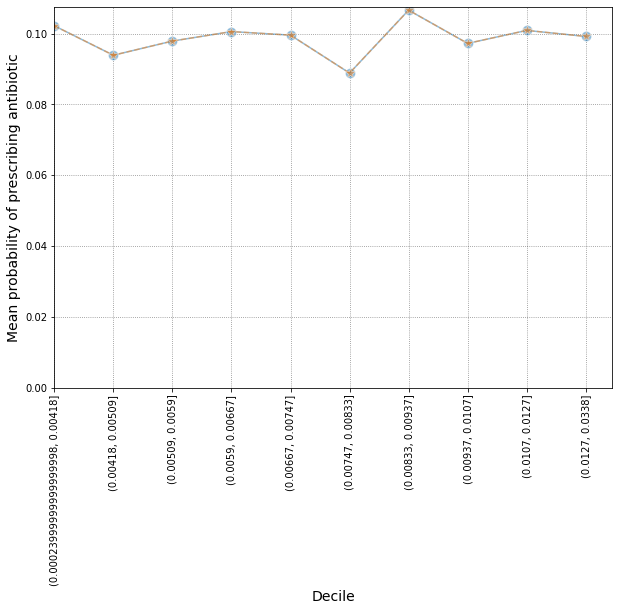


LR AUROC with development and validation data: 0.54933 and 0.49334
RF AUROC with development and validation data: 0.74980 and 0.49108
LR coefficients:
                                               OR  Lower CI  Upper CI
age_cat_15_24                           0.916708       NaN       NaN
age_cat_25_34                           0.763599       NaN       NaN
age_cat_35_44                           0.873913       NaN       NaN
age_cat_45_54                           0.810484       NaN       NaN
age_cat_55_64                           0.909302       NaN       NaN
age_cat_65_74                           0.974851       NaN       NaN
age_cat_75_more                         0.976699       NaN       NaN
sex_female                              0.645778       NaN       NaN
sex_male                                0.664712       NaN       NaN
CCI_cat_high                            0.874736  0.000000       inf
CCI_cat_low                             0.861075  0.000000       inf
CCI_cat_medium     

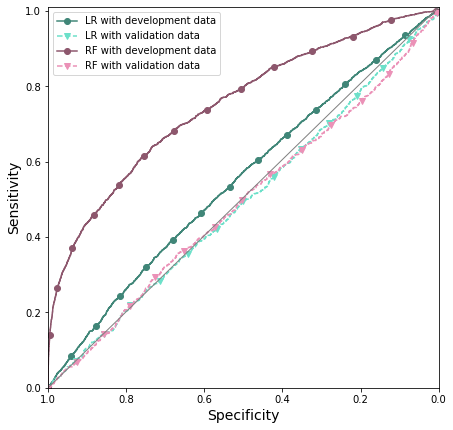

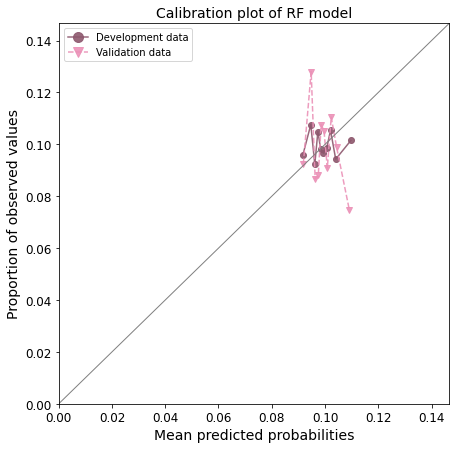

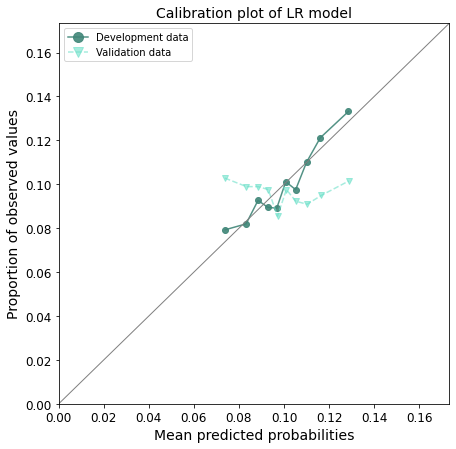

In [80]:
#build cox model for hosp prediction using non ab users' data
prob_pred_urti_combined_no_abs_prevl_post_2nd_lockdown, prob_pred_urti_combined_no_abs_prevl_post_2nd_lockdown_bin = cox_build('urti_combined', 'prevl_post_2nd_lockdown', data_urti_combined_prevl_post_2nd_lockdown, data_urti_combined_no_abs_prevl_post_2nd_lockdown)

#build rf and lr models
prob_pred_enc_lr_rf_prevl_post_2nd_lockdown, data_enc_dev_prevl_post_2nd_lockdown, data_enc_val_prevl_post_2nd_lockdown, lr_pred_dev_prevl_post_2nd_lockdown, lr_pred_val_prevl_post_2nd_lockdown, rf_pred_dev_prevl_post_2nd_lockdown, rf_pred_val_prevl_post_2nd_lockdown = lr_rf_build_risk('urti_combined', 'prevl_post_2nd_lockdown', prob_pred_urti_combined_no_abs_prevl_post_2nd_lockdown)

#calibration plots of rf and lr
calibration_rf_lr('urti_combined', 'prevl_post_2nd_lockdown', data_enc_dev_prevl_post_2nd_lockdown, data_enc_val_prevl_post_2nd_lockdown, lr_pred_dev_prevl_post_2nd_lockdown, lr_pred_val_prevl_post_2nd_lockdown, rf_pred_dev_prevl_post_2nd_lockdown, rf_pred_val_prevl_post_2nd_lockdown)